In [1]:
import pandas as pd
#Module 2
import numpy as np
import seaborn as sn
import re
from sklearn import preprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

#Module 3
import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import datetime

from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Read in the data file
df = pd.read_csv('/Users/mattcostantino/Desktop/CMU/Integrated Analytics/LoanStats3b.csv')

# Reset index and rename column headers
df.reset_index(inplace=True)
df.columns = df.iloc[0]
df.drop(0, axis = 0, inplace=True)
df.reset_index(inplace=True)
df.drop('index', inplace=True, axis=1)

In [3]:
df.isna().sum()

0
id                                     0
member_id                              2
loan_amnt                              2
funded_amnt                            2
funded_amnt_inv                        2
term                                   2
int_rate                               2
installment                            2
grade                                  2
sub_grade                              2
emp_title                          11728
emp_length                          7879
home_ownership                         2
annual_inc                             2
verification_status                    2
issue_d                                2
loan_status                            2
pymnt_plan                             2
url                                    2
desc                              106663
purpose                                2
title                                  9
zip_code                               2
addr_state                             2
dti           

In [4]:
# Remove all non IDs from the id column
df.id = pd.to_numeric(df.id, errors='coerce')
df = df[~df.id.isna()]
df.id = df.id.astype(int)

In [5]:
# Select certian columns to review

columns_to_pick = ['id','loan_amnt','funded_amnt','term','int_rate',
                    'installment','grade','emp_length', 'home_ownership',
                    'annual_inc','issue_d',
                    'loan_status','purpose','dti', 'delinq_2yrs',
                    'earliest_cr_line','pub_rec', 'revol_bal','revol_util', 'total_pymnt',
                    'last_pymnt_d', 'recoveries','total_rec_late_fee', 'open_acc', 'total_acc', 'out_prncp']

float_columns = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                 'dti', 'revol_bal', 'delinq_2yrs', 'pub_rec',
                 'total_pymnt', 'recoveries', 'total_rec_late_fee', 'open_acc', 'total_acc', 
                 'out_prncp']

categorical_columns = ['term', 'grade', 'emp_length', 'home_ownership',
                       'loan_status', 'purpose']

percent_columns = ['int_rate', 'revol_util']

date_columns = ['issue_d','earliest_cr_line', 'last_pymnt_d']

In [6]:
# Convert float columns to type float
df[float_columns] = df[float_columns].astype(float)

# Convert percent columns to percent
for column in percent_columns:
    df[column] = df[column].str.rstrip('%').astype('float') 

# Convert loan type
df = df[df.loan_status.isin(['Charged Off', 'Default', 'Fully Paid'])]

In [7]:
for column in percent_columns:
    print(df[column].head())

4     13.53
6     12.85
7     13.53
10     7.62
12     7.62
Name: int_rate, dtype: float64
4     54.5
6     54.2
7     68.8
10    55.7
12    54.6
Name: revol_util, dtype: float64


In [8]:
for column in date_columns:
    df[column] = '1-' + df[column]
    print(df[column].head())

4     1-Dec-2013
6     1-Dec-2013
7     1-Dec-2013
10    1-Dec-2013
12    1-Dec-2013
Name: issue_d, dtype: object
4     1-Jun-1998
6     1-May-1991
7     1-Oct-1998
10    1-Sep-2003
12    1-Nov-1994
Name: earliest_cr_line, dtype: object
4     1-May-2015
6     1-Jul-2014
7     1-Sep-2015
10    1-Jun-2016
12    1-Aug-2014
Name: last_pymnt_d, dtype: object


In [9]:
# Convert data columns to date type
for column in date_columns:
    df[column] = pd.to_datetime(df[column])

In [10]:
df_final = df[columns_to_pick]

In [11]:
df_final.isna().sum()

0
id                       0
loan_amnt                0
funded_amnt              0
term                     0
int_rate                 0
installment              0
grade                    0
emp_length            5792
home_ownership           0
annual_inc               0
issue_d                  0
loan_status              0
purpose                  0
dti                      0
delinq_2yrs              0
earliest_cr_line         0
pub_rec                  0
revol_bal                0
revol_util             102
total_pymnt              0
last_pymnt_d           150
recoveries               0
total_rec_late_fee       0
open_acc                 0
total_acc                0
out_prncp                0
dtype: int64

In [12]:
# Drop NaN values
df_final = df[columns_to_pick].dropna(axis=0)
df_final.head()
df_final.shape

(139687, 26)

array([[<AxesSubplot: title={'center': 'int_rate'}>,
        <AxesSubplot: title={'center': 'revol_util'}>]], dtype=object)

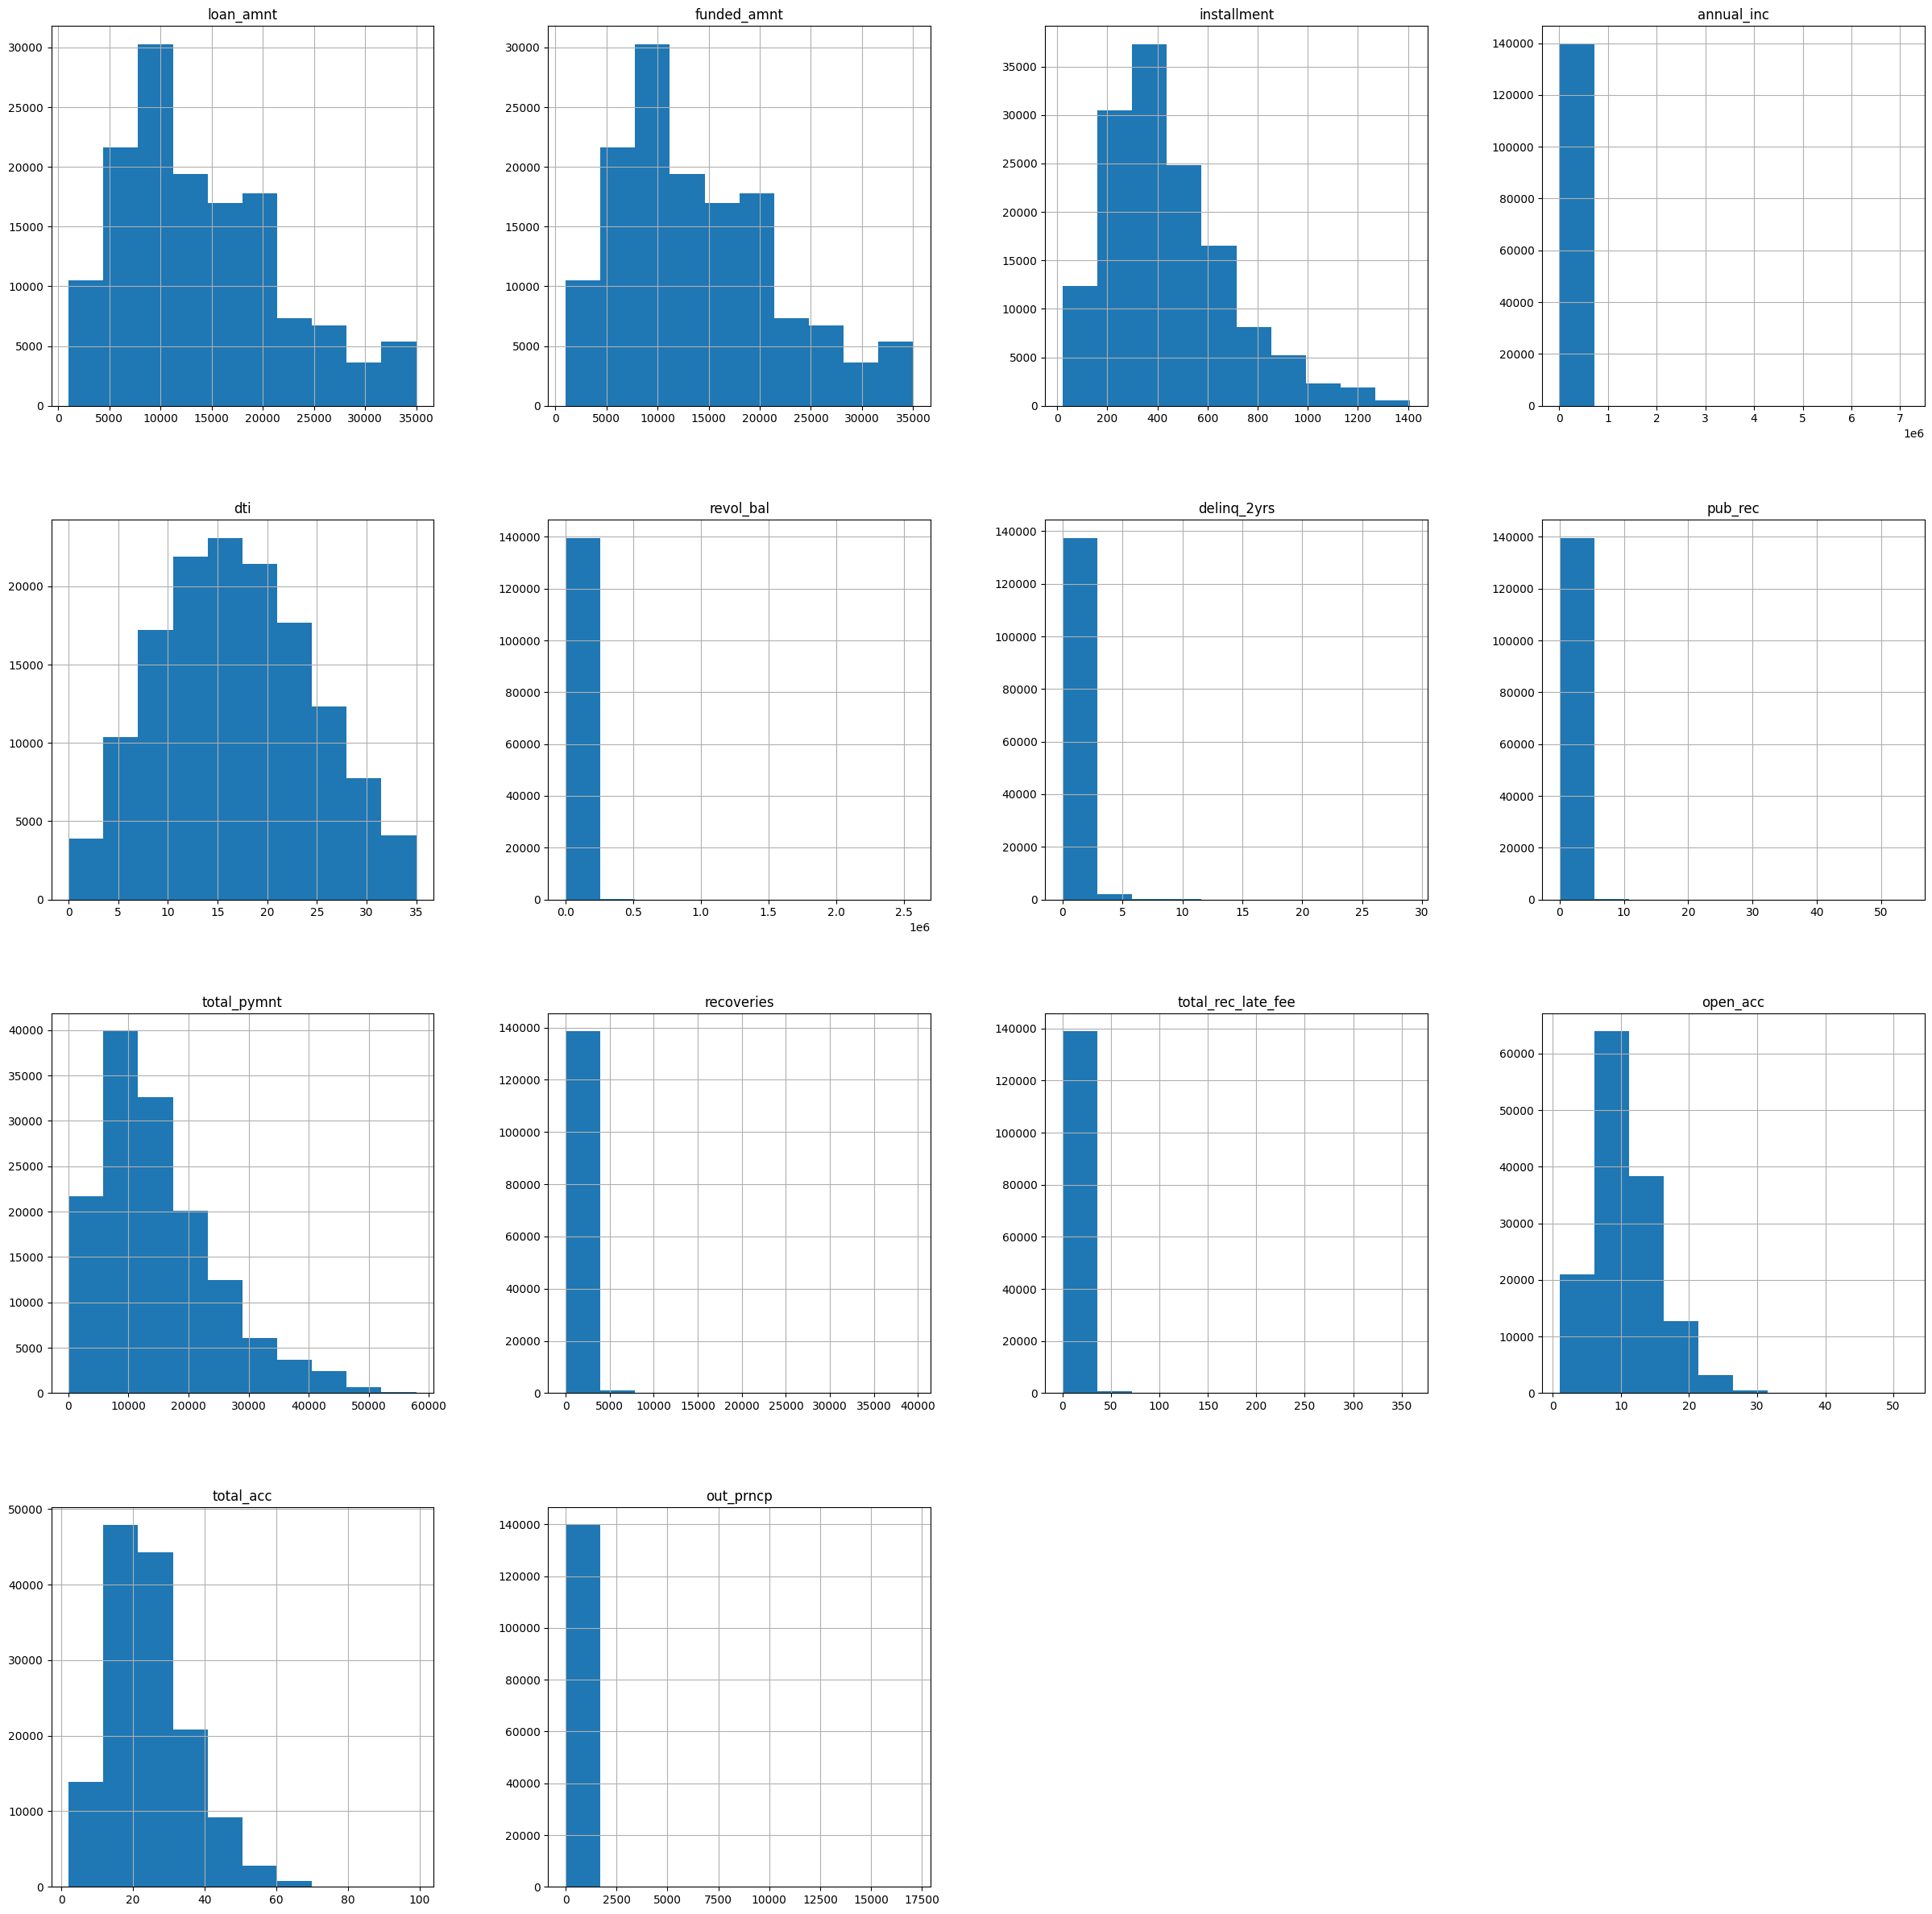

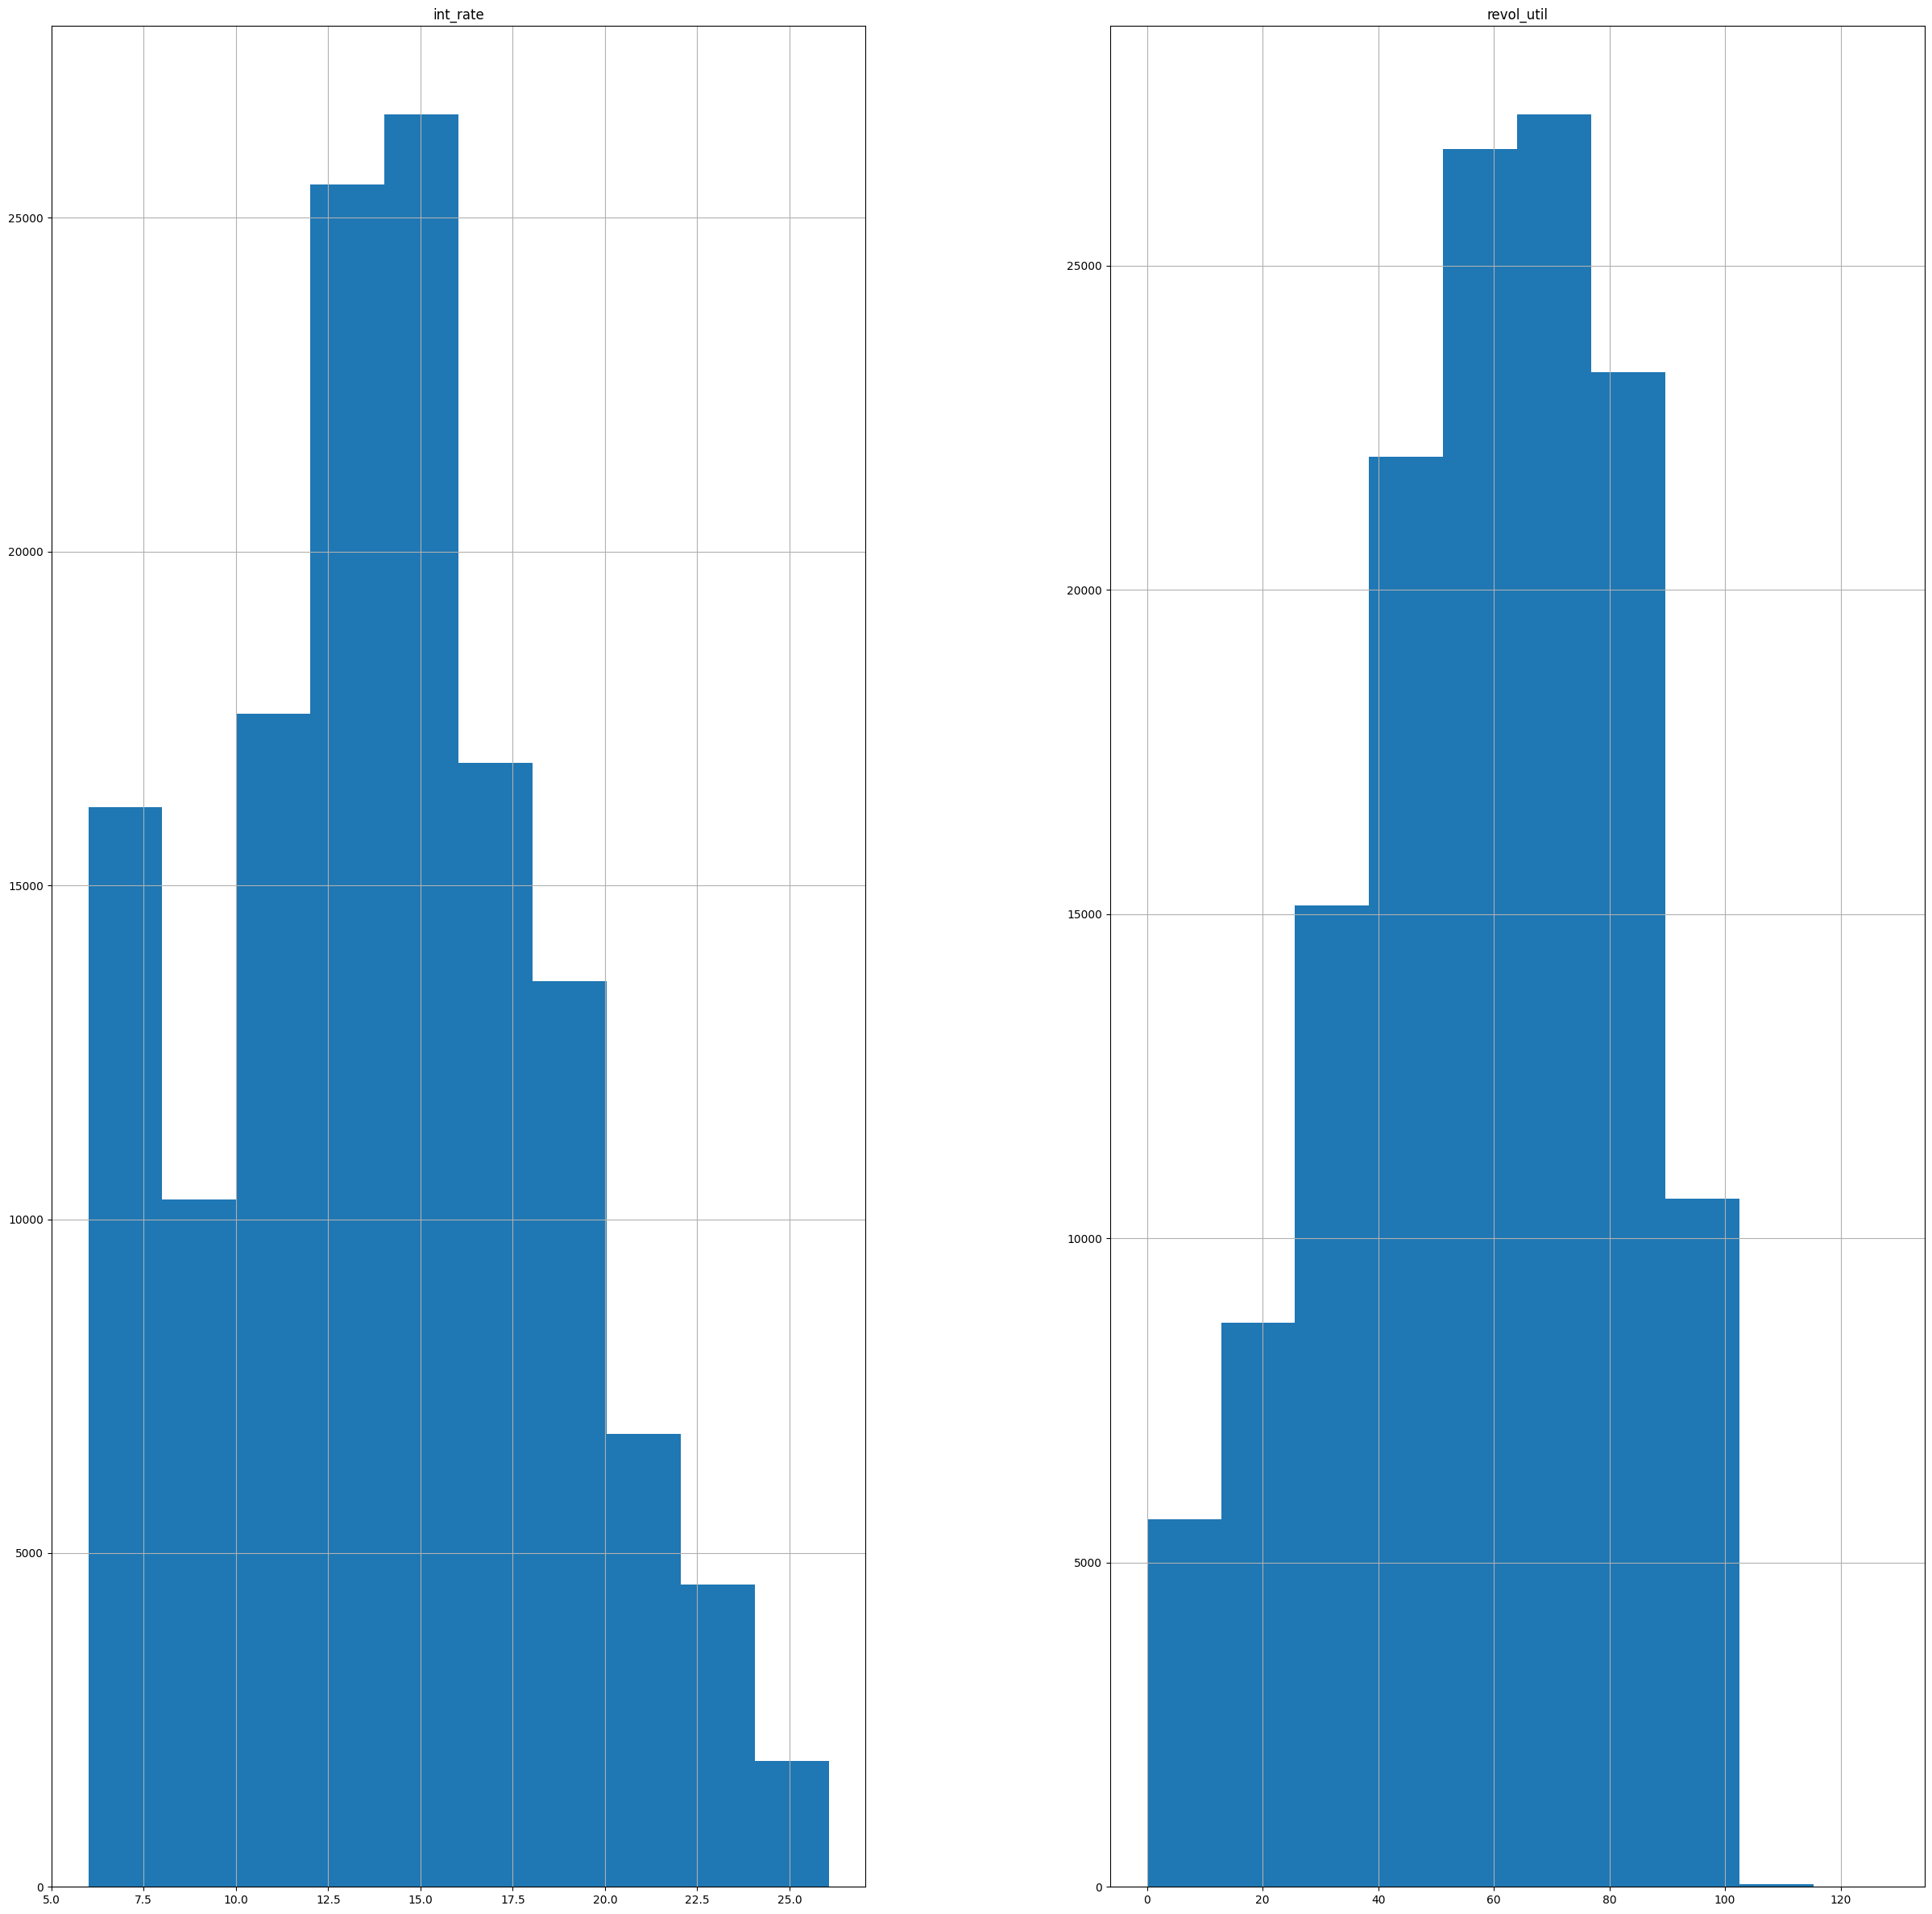

In [13]:
# Plot distributions of data
df_final[float_columns].hist(figsize=(30,30))

df_final[percent_columns].hist(figsize=(30,30))


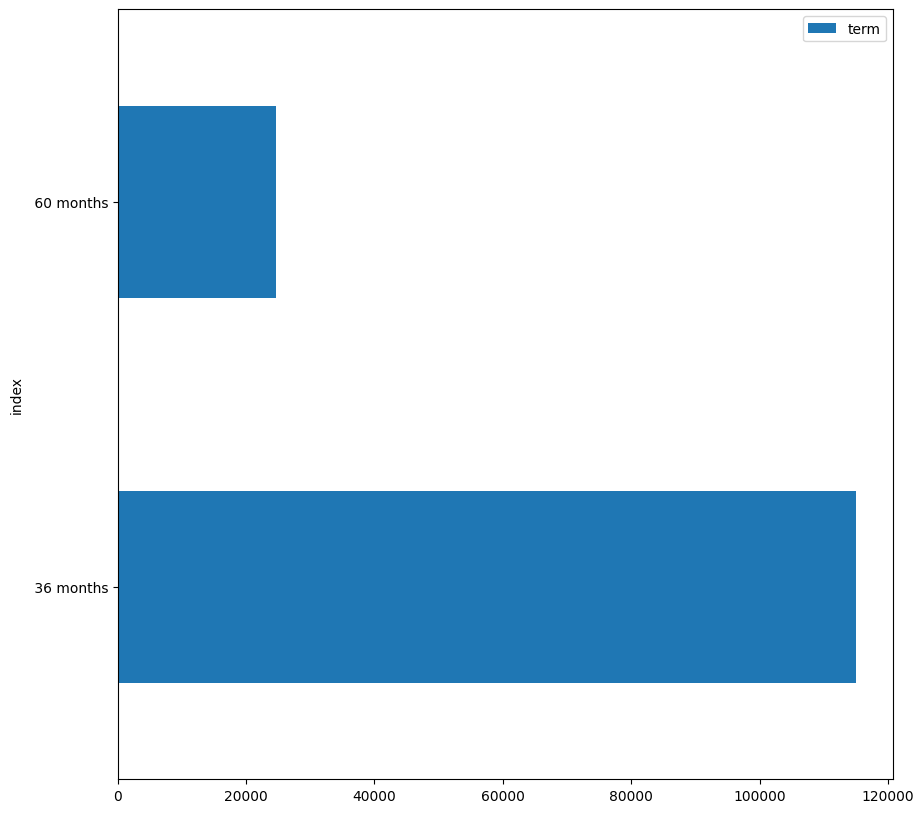

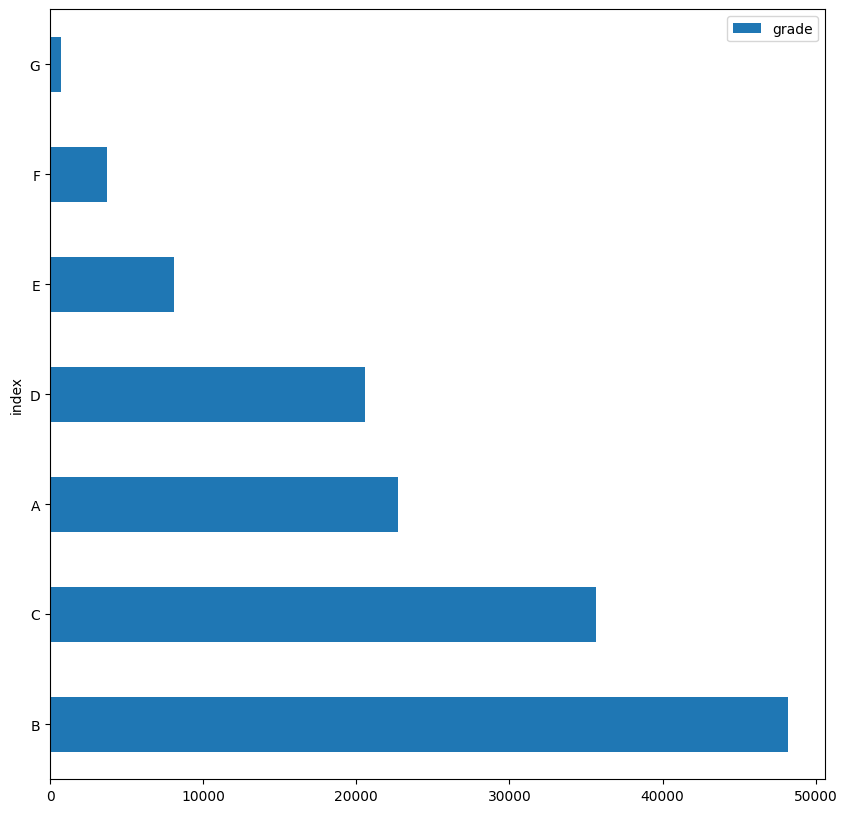

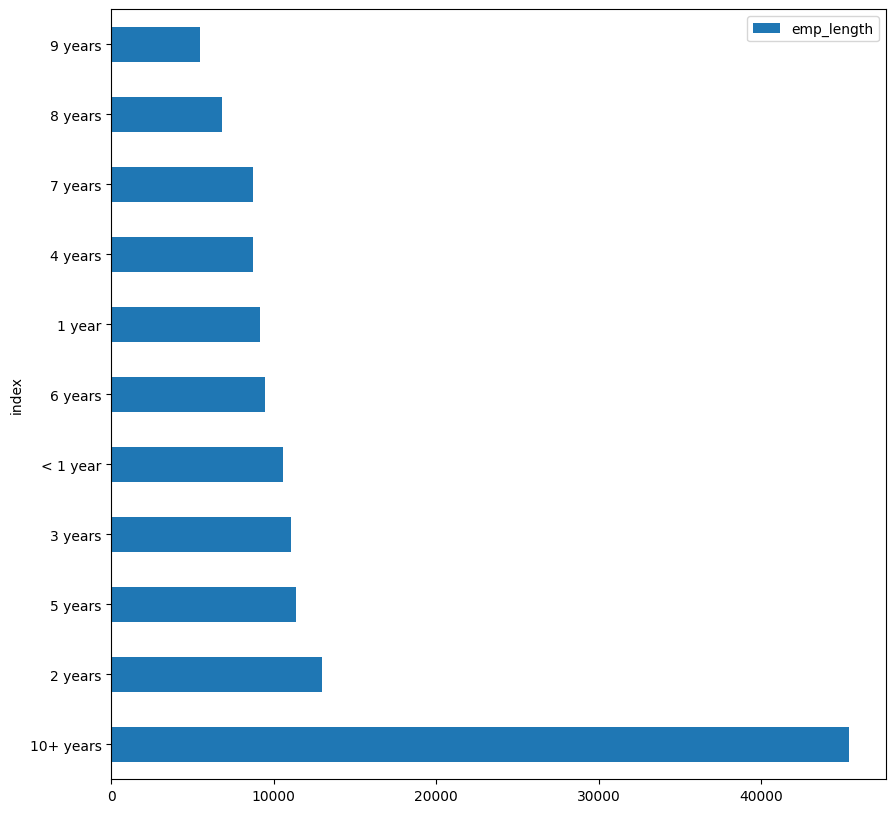

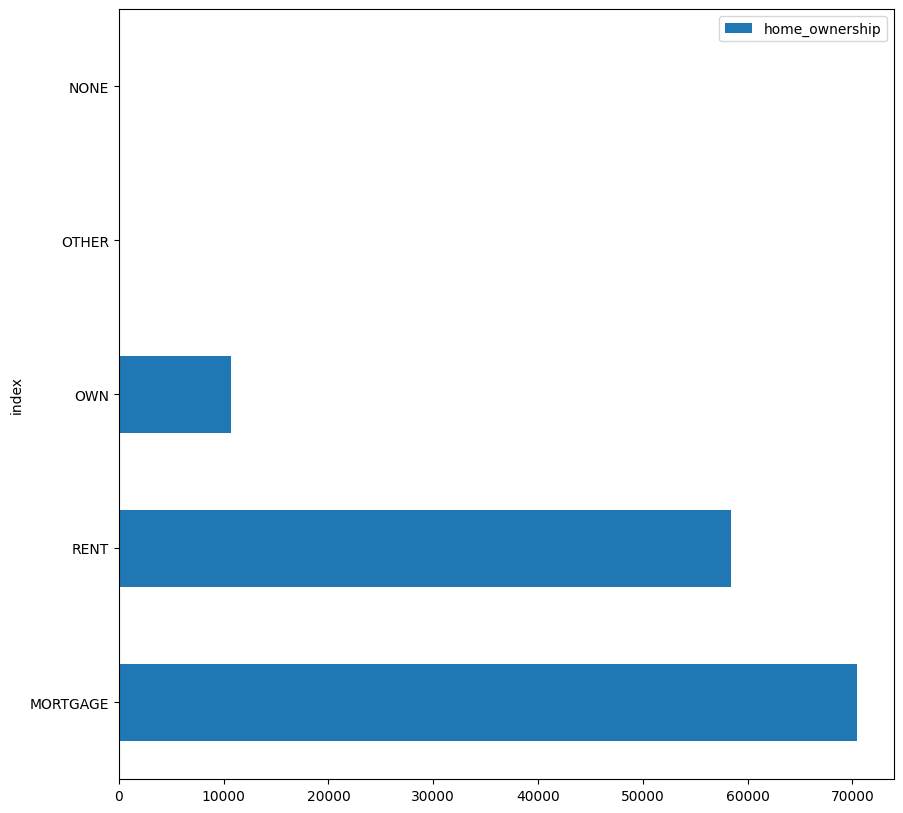

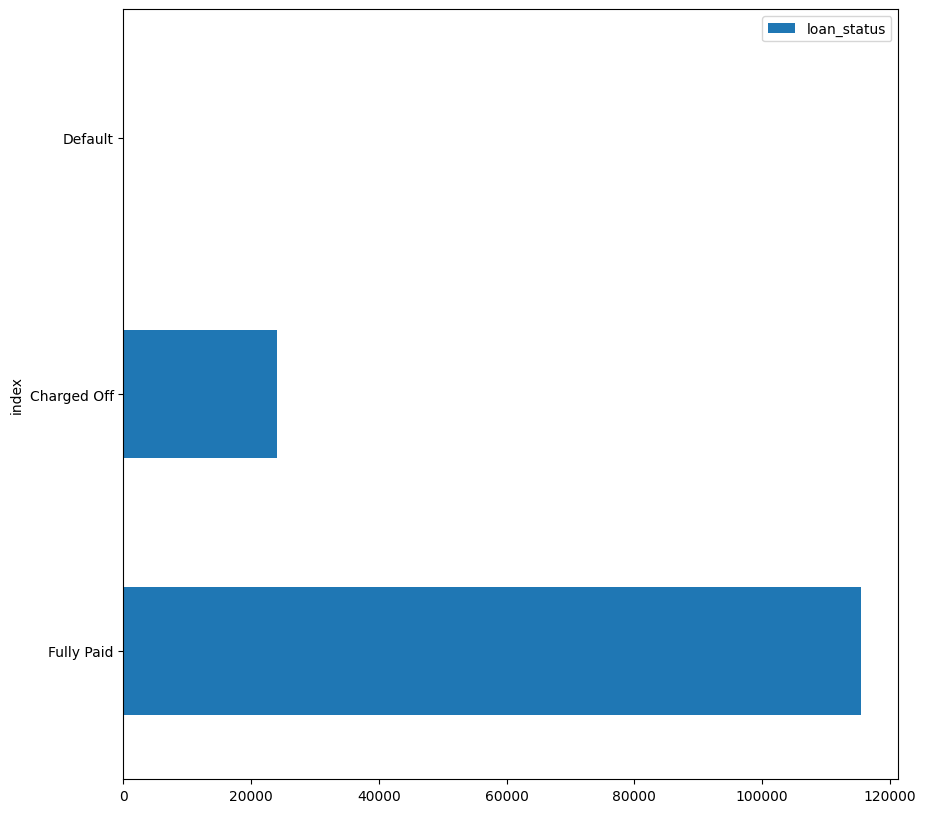

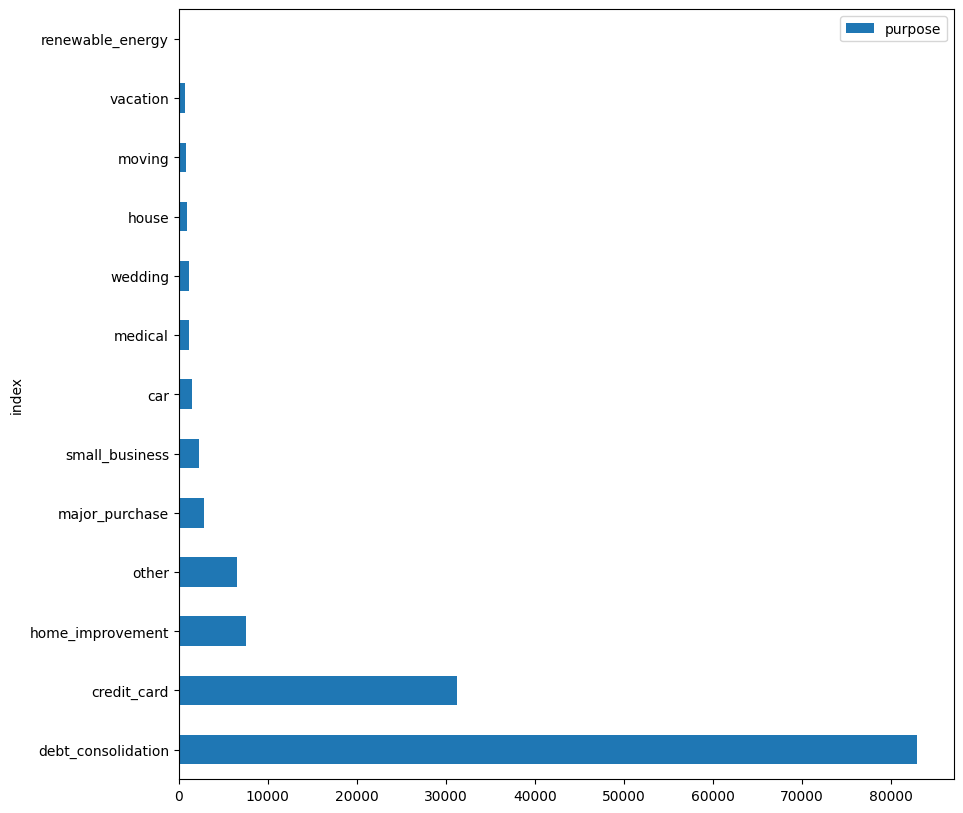

In [14]:
# Plot categorical features
for column in categorical_columns:
    temp = pd.DataFrame(df_final[column].value_counts()).reset_index()
    temp.plot.barh(x=0, figsize=(10,10))

In [15]:
df_final = df_final[(df_final['home_ownership'] != 'NONE') | (df_final['home_ownership'] != 'OTHER')]

In [16]:
# Handle outliers
df_final = df_final[df_final['annual_inc'] < 1000000]
df_final = df_final[df_final['revol_bal'] < 200000]
df_final = df_final[df_final['delinq_2yrs'] < 20]
df_final = df_final[df_final['pub_rec'] < 20]
df_final = df_final[df_final['total_rec_late_fee'] < 250]
df_final = df_final[df_final['recoveries'] < 30000]



In [17]:
df_final['loan_status'] = df_final['loan_status'].replace(['Charged Off'], 'Default')
print(df_final.loan_status.value_counts())
df_final.to_csv('loans_data.csv')
loans_data = df_final.copy()

Fully Paid    115426
Default        24087
Name: loan_status, dtype: int64


In [18]:
# df_final['annual_inc'].plot.box(figsize=(30,30))
# df_final['revol_bal'].plot.box(figsize=(30,30))
# df_final['delinq_2yrs'].plot.box(figsize=(30,30))
# df_final['pub_rec'].plot.box(figsize=(30,30))
# df_final['total_rec_late_fee'].plot.box(figsize=(30,30))
# df_final['recoveries'].plot.box(figsize=(30,30))

In [19]:
#Module 2

In [20]:
#Step 1: read the data from Week 1
#loans_final = pd.read_csv("loans_data.csv")
#loans_final = df_final
#loans_final.describe()
loans_final = loans_data.copy()
loans_final.describe()

,id,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,pub_rec,revol_bal,revol_util,total_pymnt,recoveries,total_rec_late_fee,open_acc,total_acc,out_prncp
count,1.395130e+05,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000,139513.000000
mean,4.372270e+06,13941.142582,13938.169561,14.067628,440.641199,72251.508399,16.802677,0.229004,0.097833,15632.587723,58.020302,14922.735711,193.614875,0.779313,10.981005,24.566750,0.836561
std,2.674074e+06,7955.088476,7952.143409,4.381078,244.419848,43643.744961,7.576369,0.680896,0.352342,14313.998996,23.241612,9662.607512,782.264830,5.749254,4.586234,11.137877,87.320959
min,5.852400e+04,1000.000000,1000.000000,6.000000,21.620000,5000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.690000,0.000000,0.000000,1.000000,2.000000,0.000000
25%,1.587034e+06,8000.000000,8000.000000,11.140000,266.180000,45000.000000,11.080000,0.000000,0.000000,6962.000000,42.000000,7701.149318,0.000000,0.000000,8.000000,16.000000,0.000000
50%,3.812386e+06,12000.000000,12000.000000,14.090000,392.640000,62400.000000,16.490000,0.000000,0.000000,12092.000000,60.200000,12630.040264,0.000000,0.000000,10.000000,23.000000,0.000000
75%,6.542817e+06,19075.000000,19075.000000,17.270000,573.390000,87000.000000,22.260000,0.000000,0.000000,20110.000000,76.400000,20192.537519,0.000000,0.000000,14.000000,31.000000,0.000000
max,1.023482e+07,35000.000000,35000.000000,26.060000,1408.130000,995000.000000,34.990000,18.000000,10.000000,199968.000000,128.100000,57898.139904,29282.070000,220.350000,52.000000,99.000000,17062.010000


In [21]:
print(df_final.loan_status.value_counts())

Fully Paid    115426
Default        24087
Name: loan_status, dtype: int64


In [22]:
for column in date_columns:
    loans_final[column] = pd.to_datetime(df[column])
    print(loans_final[column].head())

4    2013-12-01
6    2013-12-01
7    2013-12-01
10   2013-12-01
12   2013-12-01
Name: issue_d, dtype: datetime64[ns]
4    1998-06-01
6    1991-05-01
7    1998-10-01
10   2003-09-01
12   1994-11-01
Name: earliest_cr_line, dtype: datetime64[ns]
4    2015-05-01
6    2014-07-01
7    2015-09-01
10   2016-06-01
12   2014-08-01
Name: last_pymnt_d, dtype: datetime64[ns]


In [23]:
#Step 2: Calculate return for each loan
#Define the names of the four columns we'll be calculating

return_columns = ['ret_PESS','ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']

#Remove rows for loands which were paid back on the date they were issues


loans_final['loan_length'] = (loans_final['last_pymnt_d'] - loans_final['issue_d'])
loans_final['loan_length'] = loans_final['loan_length']/ np.timedelta64(1, 'M')
n = len(loans_final)

n

139513

In [24]:
loans_final['loan_length'].describe()

count    139513.000000
mean         22.445365
std          10.779396
min           0.000000
25%          13.963326
50%          22.965564
75%          32.986304
max          52.994928
Name: loan_length, dtype: float64

In [25]:
loans_final = loans_final[loans_final['loan_length'] != 0]
print("Removed " + str(n-len(loans_final)) + ' rows')

Removed 5 rows


In [26]:
#Parse numbers from string

#loans_final['term'] =str(loans_final['term'])
loans_final['term_num'] =  loans_final['term'].str[:3]
loans_final['term_num'] = pd.to_numeric(loans_final['term_num'])

In [27]:
loans_final['term_num']

4         36
6         36
7         36
10        36
12        36
          ..
188115    36
188117    36
188118    36
188119    36
188120    36
Name: term_num, Length: 139508, dtype: int64

In [28]:
loans_final.isna().sum()
loans_final.dropna()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,pub_rec,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,total_rec_late_fee,open_acc,total_acc,out_prncp,loan_length,term_num
4,10129506,20800.0,20800.0,36 months,13.53,706.16,B,10+ years,RENT,81500.0,2013-12-01,Fully Paid,debt_consolidation,16.73,0.0,1998-06-01,0.0,23473.0,54.5,23926.640008,2015-05-01,0.0,0.0,29.0,41.0,0.0,16.953120,36
6,10179520,3000.0,3000.0,36 months,12.85,100.87,B,10+ years,RENT,25000.0,2013-12-01,Fully Paid,debt_consolidation,24.68,0.0,1991-05-01,2.0,2875.0,54.2,3181.548905,2014-07-01,0.0,0.0,5.0,26.0,0.0,6.965235,36
7,10139658,12000.0,12000.0,36 months,13.53,407.40,B,10+ years,RENT,40000.0,2013-12-01,Fully Paid,debt_consolidation,16.94,0.0,1998-10-01,2.0,5572.0,68.8,13359.776858,2015-09-01,0.0,0.0,7.0,32.0,0.0,20.994271,36
10,10148122,12000.0,12000.0,36 months,7.62,373.94,A,3 years,MORTGAGE,96500.0,2013-12-01,Fully Paid,debt_consolidation,12.61,0.0,2003-09-01,0.0,13248.0,55.7,13397.539998,2016-06-01,0.0,0.0,17.0,30.0,0.0,29.996509,36
12,10149577,28000.0,28000.0,36 months,7.62,872.52,A,5 years,MORTGAGE,325000.0,2013-12-01,Fully Paid,debt_consolidation,18.55,0.0,1994-11-01,0.0,29581.0,54.6,29150.980000,2014-08-01,0.0,0.0,15.0,31.0,0.0,7.983737,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188115,1061272,8650.0,8650.0,36 months,14.65,298.38,C,9 years,RENT,55000.0,2012-01-01,Fully Paid,car,17.61,0.0,2004-08-01,0.0,8052.0,71.3,10584.619024,2014-03-01,0.0,0.0,10.0,10.0,0.0,25.955358,36
188117,1062337,12000.0,12000.0,36 months,7.90,375.49,A,3 years,MORTGAGE,42000.0,2012-01-01,Fully Paid,credit_card,9.83,0.0,2001-04-01,0.0,14378.0,52.3,13023.217719,2013-04-01,0.0,0.0,9.0,14.0,0.0,14.981827,36
188118,1062400,20500.0,20500.0,36 months,16.77,728.54,D,7 years,RENT,60000.0,2012-01-01,Fully Paid,debt_consolidation,16.40,1.0,1988-10-01,0.0,15417.0,58.4,26176.440002,2014-11-01,0.0,0.0,10.0,20.0,0.0,34.004805,36
188119,1059394,15000.0,15000.0,36 months,15.27,521.97,C,3 years,RENT,57600.0,2012-01-01,Fully Paid,small_business,8.35,2.0,2004-01-01,0.0,8897.0,33.1,18790.720008,2015-01-01,0.0,0.0,18.0,30.0,0.0,36.008953,36


In [29]:
#Calculate return using a simple annualized profit margin
#method 2
loans_final['ret_PESS'] = ((loans_final['total_pymnt'] - loans_final['funded_amnt'])/ loans_final['funded_amnt']) *(12/loans_final['term_num'])
#mthod 1
loans_final['ret_OPT'] = ((loans_final['total_pymnt'] - loans_final['funded_amnt'])/ loans_final['funded_amnt']) *(12/loans_final['loan_length'])
#if method 1 is negative then use method 2
loans_final.loc[loans_final['ret_OPT'] < 0, 'ret_OPT'] = ((loans_final['total_pymnt'] - loans_final['funded_amnt'])/ loans_final['funded_amnt']) *(12/loans_final['term_num'])
#method 3: the reinvestment return, give an investment time horizon(in months) and reinvestment rate, calculate return for each loan
def return_method_3(t,r):
    # Assuming that the total amount paid back was paid at equal
  # intervals during the duration of the loan, calculate the
  # size of each of these installment
    actual_installment = (loans_final['total_pymnt'] - loans_final['recoveries']) / loans_final['loan_length']
    # Assuming the amount is immediately re-invested at the prime
  # rate, find the total amount of money we'll have by the end
  # of the loan
    cash_by_end_of_loan = actual_installment * (1-(1+r) ** loans_final['loan_length']) / (1-(1+r))
    cash_by_end_of_loan = cash_by_end_of_loan + loans_final['recoveries']
     # Assuming that cash is then re-invested at the prime rate,
  # with monthly re-investment, until T months from the start
  # of the loan
    remaining_months = t - loans_final['loan_length']
    final_return = cash_by_end_of_loan * (1+r)** remaining_months
    return ((12/t) * ((final_return - loans_final['funded_amnt'])/loans_final['funded_amnt']))
    

In [30]:
#Apply to different time horizons
#loans_final['ret_INTa'] = loans_final['ret_INTa'].apply(return_method_3(12*5,0.001))
loans_final['ret_INTa'] = return_method_3(12*5,0.001)
loans_final['ret_INTb'] = return_method_3(12*5,0.0025)
loans_final['ret_INTc'] = return_method_3(12*5,0.005)

In [31]:
#Change return to full numbers
for column in return_columns:
    loans_final[column] = loans_final[column]*100

In [32]:
loans_final[return_columns]

,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
4,5.010641,10.640111,4.210384,6.134220,9.682277
6,2.017210,10.426003,2.431798,4.394780,8.048255
7,3.777158,6.476895,3.384438,5.167226,8.443898
10,3.882056,4.659009,3.345720,4.959281,7.904346
12,1.370214,6.178525,2.010053,3.917963,7.465493
...,...,...,...,...,...
188115,7.455179,10.340310,5.638675,7.492418,10.886031
188117,2.842271,6.829726,2.863729,4.716669,8.139898
188118,9.229984,9.771543,6.647401,8.405383,11.605238
188119,8.423822,8.421728,6.116673,7.798751,10.856530


In [33]:
loans_final[loans_final.id == 10179520]

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,pub_rec,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,total_rec_late_fee,open_acc,total_acc,out_prncp,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
6,10179520,3000.0,3000.0,36 months,12.85,100.87,B,10+ years,RENT,25000.0,2013-12-01,Fully Paid,debt_consolidation,24.68,0.0,1991-05-01,2.0,2875.0,54.2,3181.548905,2014-07-01,0.0,0.0,5.0,26.0,0.0,6.965235,36,2.01721,10.426003,2.431798,4.39478,8.048255


In [34]:
#Step 3: Visualize variables
#Include the variables of each type you want to visualize

vis_float_columns = ['loan_amnt', 'annual_inc', 'dti', 'revol_bal', 'delinq_2yrs']
vis_categorical_columns = ['term', 'grade']
vis_percentage_columns = ['int_rate','revol_util']
vis_date_columns = ['issue_d']
vis_return_columns = ['ret_PESS', 'ret_OPT']

loan_amnt


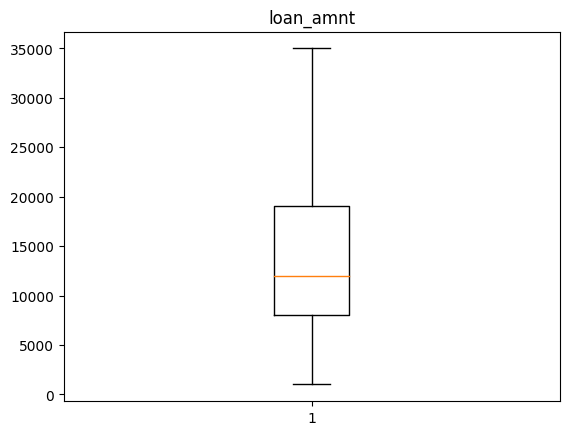

annual_inc


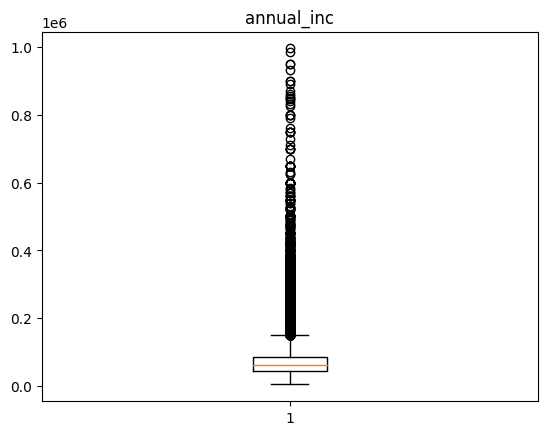

dti


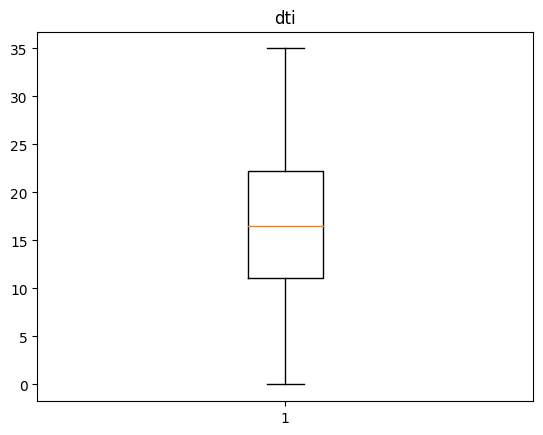

revol_bal


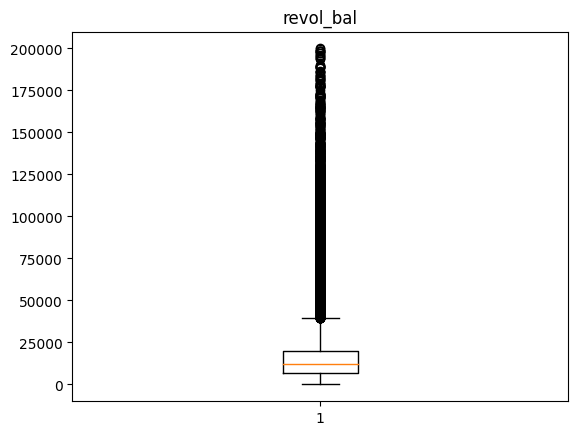

delinq_2yrs


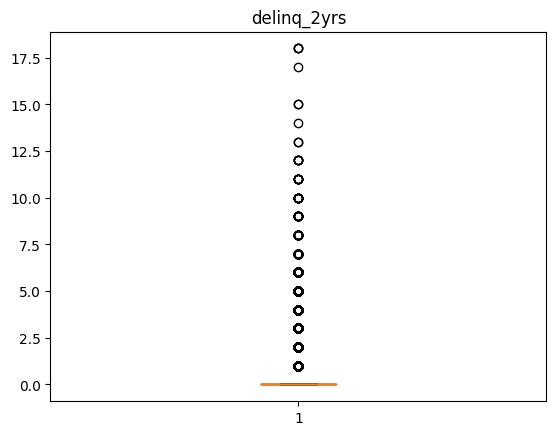

int_rate


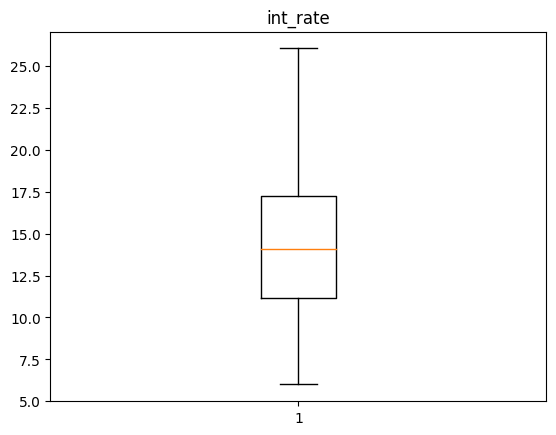

revol_util


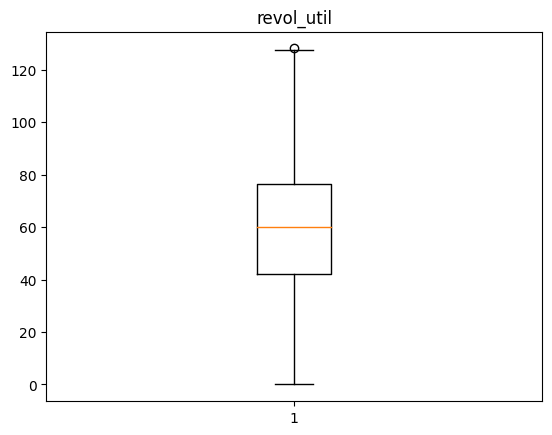

ret_PESS


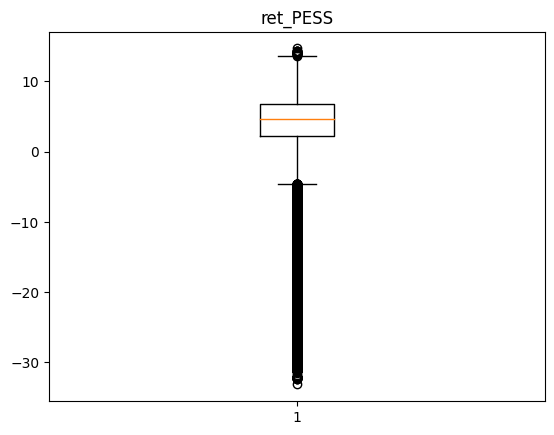

ret_OPT


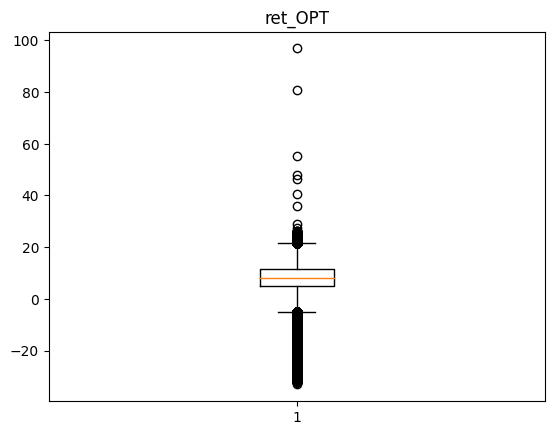

In [35]:
#Visualize continuous columns using box plots
for i in [vis_float_columns, vis_percentage_columns, vis_return_columns]:
    for x in i:
        print(x)
        plt.boxplot(loans_final[x])
        plt.title(x)
        plt.show()
    

term


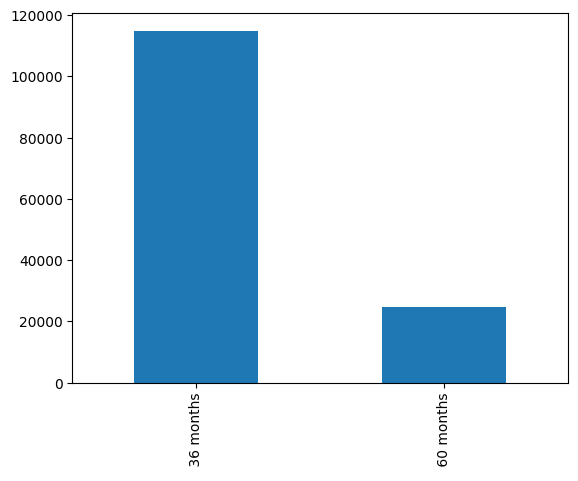

grade


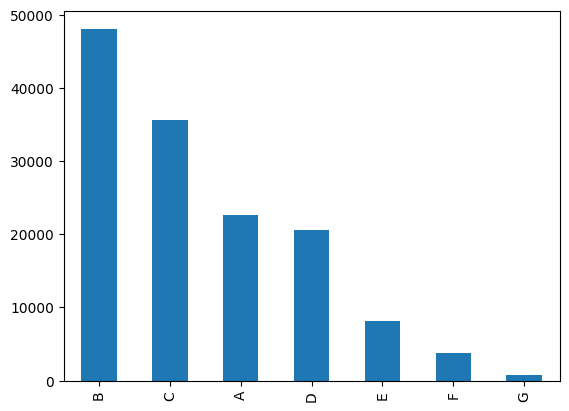

In [36]:
#Visualize categorical values
for i in vis_categorical_columns:
    print(i)
    loans_final[i].value_counts().plot(kind = 'bar')
    plt.show()

In [37]:
#Step 4: Explore return by loan grade
number_by_grade = loans_final['grade'].value_counts()
combined = number_by_grade.to_frame()
combined = combined.sort_index()
combined. rename(columns = {'grade':'count'}, inplace = True)
combined

,count
A,22688
B,48148
C,35588
D,20529
E,8085
F,3735
G,735


In [38]:
#Percentage of loans by grade
combined['percentage'] = (number_by_grade/len(loans_final))*100
#Find percentage of defaults by grade
defaults_by_grade = loans_final.groupby(['grade', 'loan_status']).size().unstack()
defaults_by_grade =  defaults_by_grade.iloc[: , :-1]



In [39]:
combined['default'] = defaults_by_grade['Default']
combined['default_pct'] = combined['default']/combined['count']*100
print(combined)


   count  percentage  default  default_pct
A  22688   16.262867     1373     6.051657
B  48148   34.512716     5890    12.233115
C  35588   25.509648     7003    19.677981
D  20529   14.715285     5191    25.286181
E   8085    5.795367     2785    34.446506
F   3735    2.677266     1521    40.722892
G    735    0.526852      324    44.081633


In [40]:
#Average return by grade
returns_by_grade = loans_final[['grade', 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']]
returns = returns_by_grade.groupby('grade').mean()

In [41]:
#Add More columns
dti_by_grade = loans_final[['grade','dti']]
dti_by_grade = dti_by_grade.groupby('grade').mean()
combined = combined.join(dti_by_grade)

annual_inc_by_grade = loans_final[['grade', 'annual_inc']]
annual_inc_by_grade = annual_inc_by_grade.groupby('grade').mean()
combined = combined.join(annual_inc_by_grade)

revol_bal_by_grade = loans_final [['grade', 'revol_bal']]
revol_bal_by_grade = revol_bal_by_grade.groupby('grade').mean()
combined = combined.join(revol_bal_by_grade)

combined = combined.join(returns)
combined

,count,percentage,default,default_pct,dti,annual_inc,revol_bal,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
A,22688,16.262867,1373,6.051657,14.543919,82516.169334,16620.064616,2.247824,4.005569,2.380273,4.013230,7.009118
B,48148,34.512716,5890,12.233115,16.677347,69885.445712,15579.261340,2.910984,5.780759,2.817753,4.494817,7.573252
C,35588,25.509648,7003,19.677981,17.464097,68365.208464,15120.379566,2.578030,6.817826,2.644022,4.327971,7.421801
D,20529,14.715285,5191,25.286181,17.664477,68427.362545,14524.258269,2.522466,7.414851,2.573505,4.256066,7.348064
E,8085,5.795367,2785,34.446506,18.000850,78323.037233,17123.425850,1.276203,8.041453,1.789463,3.434760,6.461312
F,3735,2.677266,1521,40.722892,18.219438,80330.551775,17243.174565,0.125709,8.252752,1.012459,2.618836,5.576398
G,735,0.526852,324,44.081633,18.259878,97537.509986,19860.438095,-0.324291,8.384737,0.589396,2.173854,5.092448


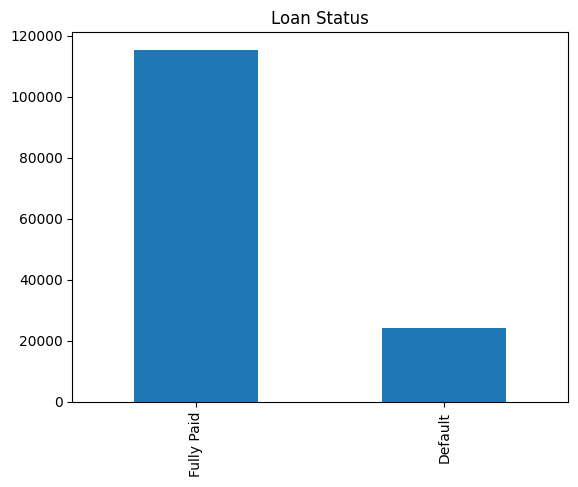

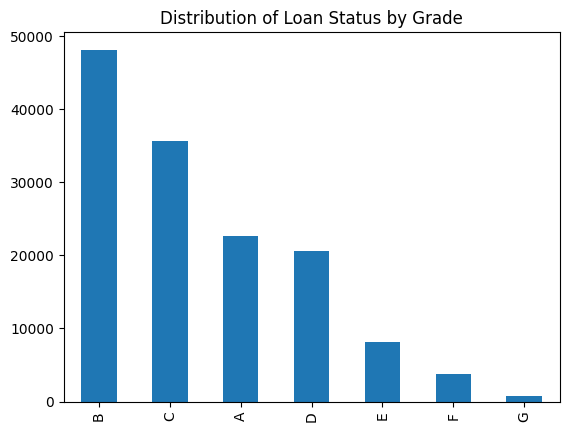

In [42]:
## Step 5: Create some multi-variable summaries
# Simple histograms of the default variable versus categorical variables
# barplot is called on the table command which automatically bins the variable given to it 
# This first one shows the histograms of the defaulters

loans_final['loan_status'].value_counts().plot(kind = 'bar')
plt.title('Loan Status')
plt.show()

loans_final['grade'].value_counts().plot(kind = 'bar')
plt.title('Distribution of Loan Status by Grade')
plt.show()

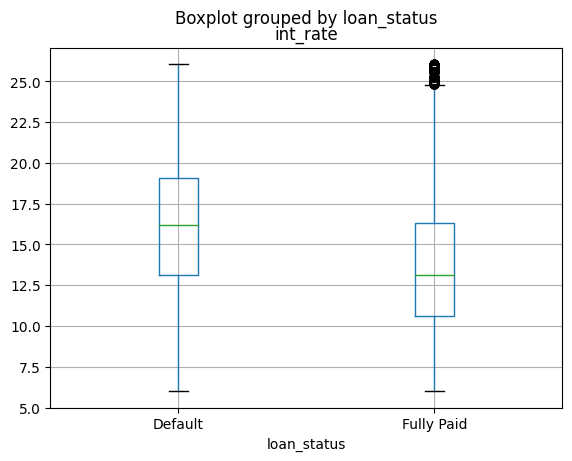

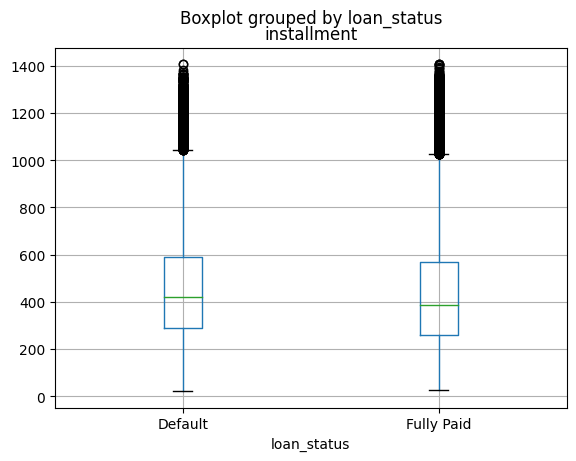

In [43]:
loans_final.boxplot(column = 'int_rate', by = 'loan_status')
plt.show()

loans_final.boxplot(column = 'installment', by = 'loan_status')
plt.show()

In [44]:
#compute correlation matrix among numerical attributes in one large matrix

numerical_columns = loans_final[ ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                      'dti', 'revol_bal', 'delinq_2yrs', 'pub_rec',
                      'total_pymnt', 'recoveries','int_rate', 'revol_util']]
numerical_columns.corr()

,loan_amnt,funded_amnt,installment,annual_inc,dti,revol_bal,delinq_2yrs,pub_rec,total_pymnt,recoveries,int_rate,revol_util
0,,,,,,,,,,,,
loan_amnt,1.000000,0.999744,0.961843,0.422042,0.033815,0.386206,0.007901,-0.067385,0.875764,0.207972,0.169971,0.081883
funded_amnt,0.999744,1.000000,0.962164,0.422004,0.033804,0.386202,0.007925,-0.067310,0.876005,0.207964,0.169774,0.081840
installment,0.961843,0.962164,1.000000,0.417758,0.035351,0.376108,0.019419,-0.060417,0.857288,0.173629,0.162222,0.116653
annual_inc,0.422042,0.422004,0.417758,1.000000,-0.227155,0.377015,0.079746,-0.017315,0.398817,0.038192,-0.040132,0.018617
dti,0.033815,0.033804,0.035351,-0.227155,1.000000,0.185351,-0.010360,-0.059319,0.011089,0.057206,0.143216,0.219514
revol_bal,0.386206,0.386202,0.376108,0.377015,0.185351,1.000000,-0.035978,-0.110208,0.352051,0.054780,-0.007699,0.258686
delinq_2yrs,0.007901,0.007925,0.019419,0.079746,-0.010360,-0.035978,1.000000,-0.023583,0.010524,0.017463,0.101155,-0.015537
pub_rec,-0.067385,-0.067310,-0.060417,-0.017315,-0.059319,-0.110208,-0.023583,1.000000,-0.060319,-0.006455,0.068382,-0.049801
total_pymnt,0.875764,0.876005,0.857288,0.398817,0.011089,0.352051,0.010524,-0.060319,1.000000,-0.069383,0.125872,0.082445


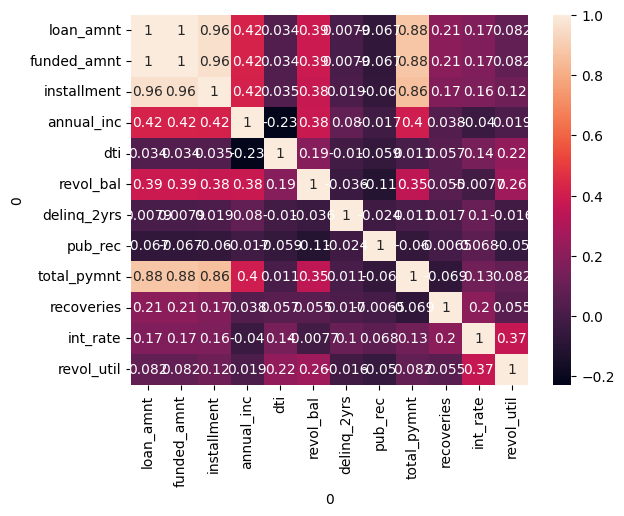

In [45]:
#Generate a heat map of correlated predictors
corrMatrix = numerical_columns.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

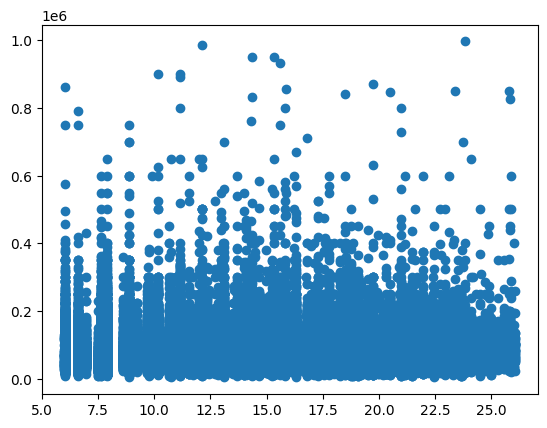

In [46]:
#Scatter Plots

plt.scatter(loans_final['int_rate'], loans_final['annual_inc'])

In [47]:
#Step 6: PCA and K means
# convert employment length to numeric values

#loans_final['emp_length'] = loans_final.emp_length.str.findall(r'\d+')
# # emp_length conversion
emp_length_dict = {'10+ years': 10, '2 years': 2, '5 years': 5, '3 years': 3, '< 1 year': 0, '6 years': 6, '1 year': 1, '4 years': 4, '7 years': 7, '8 years': 8, '9 years': 9}

for key,value in emp_length_dict.items():
    loans_final.emp_length.replace(key, value, inplace = True)

In [48]:
# Include grade along with some numerical features for further descriptive analysis
# ! (C) Choose more variables for K-Means and PCA
#   You can modify the list in the previous line to include more numerical variables
#   These variables will then be used for the subsequent KMeans and PCA
loans_analysis = loans_final[['int_rate', 'annual_inc','loan_amnt','grade','dti',  'revol_bal', 'emp_length']]
# Remove rows where emp_length has an NA value
loans_analysis = loans_analysis.dropna(axis = 0)
loans_analysis

,int_rate,annual_inc,loan_amnt,grade,dti,revol_bal,emp_length
4,13.53,81500.0,20800.0,B,16.73,23473.0,10
6,12.85,25000.0,3000.0,B,24.68,2875.0,10
7,13.53,40000.0,12000.0,B,16.94,5572.0,10
10,7.62,96500.0,12000.0,A,12.61,13248.0,3
12,7.62,325000.0,28000.0,A,18.55,29581.0,5
...,...,...,...,...,...,...,...
188115,14.65,55000.0,8650.0,C,17.61,8052.0,9
188117,7.90,42000.0,12000.0,A,9.83,14378.0,3
188118,16.77,60000.0,20500.0,D,16.40,15417.0,7
188119,15.27,57600.0,15000.0,C,8.35,8897.0,3


In [49]:
# Standardize the data set with mean 0 and variance 1 scale
# Exclude col number 4 corresponding to the grade
sc = StandardScaler()
sc_loans_analysis = loans_analysis.drop('grade', axis = 1)
scaled = sc.fit_transform(sc_loans_analysis)
sc_loans_analysis = pd.DataFrame(scaled)
sc_loans_analysis.columns = ['int_rate', 'annual_inc','loan_amnt','dti','revol_bal','emp_length']
sc_loans_analysis.describe()

,int_rate,annual_inc,loan_amnt,dti,revol_bal,emp_length
count,1.395080e+05,1.395080e+05,1.395080e+05,1.395080e+05,1.395080e+05,1.395080e+05
mean,1.692981e-16,4.307832e-16,-4.059284e-17,-4.264031e-16,2.847101e-17,9.065904e-18
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.841511e+00,-1.540903e+00,-1.626760e+00,-2.217782e+00,-1.092129e+00,-1.678077e+00
25%,-6.682481e-01,-6.244015e-01,-7.468279e-01,-7.553345e-01,-6.057542e-01,-8.362185e-01
50%,5.122873e-03,-2.257232e-01,-2.440094e-01,-4.126949e-02,-2.473658e-01,5.640231e-03
75%,7.309939e-01,3.379253e-01,6.453510e-01,7.203119e-01,3.127996e-01,1.128119e+00
max,2.737411e+00,2.114251e+01,2.647198e+00,2.400543e+00,1.287790e+01,1.128119e+00


In [50]:
# Perform K-Means analysis with K = 4, then compare this with the given grades
cluster_columns = sc_loans_analysis[['int_rate', 'annual_inc','loan_amnt','emp_length','dti','revol_bal']]
# Here you can experiment with using any subset of all the columns you chose
#   to run the K-Means analysis. Pay attention to not including too many vars
#   that capture the same signal however.
cluster_columns.head()

,int_rate,annual_inc,loan_amnt,emp_length,dti,revol_bal
0,-0.122703,0.211906,0.862192,1.128119,-0.009592,0.547726
1,-0.277921,-1.082652,-1.375351,1.128119,1.039727,-0.891277
2,-0.122703,-0.738964,-0.244009,1.128119,0.018126,-0.702861
3,-1.471728,0.555595,-0.244009,-0.836219,-0.553390,-0.166606
4,-1.471728,5.791111,1.767265,-0.274979,0.230630,0.974438


In [51]:
#Run k=4

cluster4 = KMeans(init = 'random', n_clusters = 4, random_state = 42)
cluster4.fit(cluster_columns)
#y_cluster4 = cluster4.predict(cluster_columns)
print('Inertia: ' + str(cluster4.inertia_))
print('Cluster Centers: ' + str(cluster4.cluster_centers_))
print('Iterations:' + str(cluster4.n_iter_))
print('Labels:' + str(cluster4.labels_[:5]))

Inertia: 535369.3480479653
Cluster Centers: [[-0.4616442  -0.00762574 -0.27369895  0.79714636 -0.63161779 -0.27003091]
 [-0.13941878 -0.32174184 -0.46104422 -1.04154605 -0.28602765 -0.38692878]
 [ 0.2311113   1.2714668   1.48258524  0.12785393 -0.10699818  1.21335776]
 [ 0.49358058 -0.37599626 -0.06817525  0.36091242  1.04471921  0.00221301]]
Iterations:27
Labels:[0 3 0 1 2]


1 - 837047.9999999991
2 - 679414.5336255744
3 - 594127.1129730577
4 - 535377.7906862799
5 - 488216.4156303591
6 - 453506.62150447577
7 - 423363.00119148765
8 - 398381.40385422646
9 - 377171.966503613
10 - 361140.98703389795


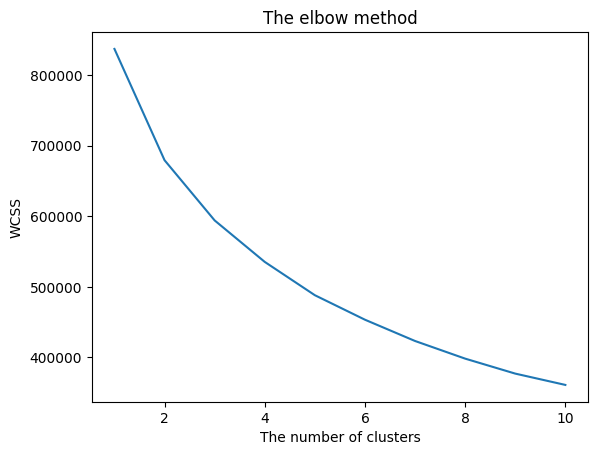

In [52]:
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=0,max_iter=500,algorithm='auto')
    clusters = kmeans.fit_predict(cluster_columns)
    print(str(i) + " - " +str(kmeans.inertia_))
    wcss.append(kmeans.inertia_)


plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('The number of clusters')
plt.ylabel('WCSS')
plt.show()

In [53]:
#Rescale data
rescaled_cluster_columns = sc.inverse_transform(cluster_columns)
rescaled_cluster_columns = pd.DataFrame(rescaled_cluster_columns, index = cluster_columns.index, columns = cluster_columns.columns)
rescaled_cluster_columns

,int_rate,annual_inc,loan_amnt,emp_length,dti,revol_bal
0,13.53,81500.0,20800.0,25.349683,15495.513112,7.931745
1,12.85,25000.0,3000.0,25.349683,30515.549614,2.803796
2,13.53,40000.0,12000.0,25.349683,15892.268793,3.475224
3,7.62,96500.0,12000.0,10.467195,7711.544510,5.386193
4,7.62,325000.0,28000.0,14.719334,18934.062349,9.452354
...,...,...,...,...,...,...
139503,14.65,55000.0,8650.0,23.223613,17158.108348,4.092629
139504,7.90,42000.0,12000.0,10.467195,2459.255017,5.667510
139505,16.77,60000.0,20500.0,18.971474,14872.039899,5.926173
139506,15.27,57600.0,15000.0,10.467195,-336.927879,4.302995


In [54]:
#Run K=5
cluster5 = KMeans(init = 'random', n_clusters = 5, random_state = 42)
cluster5.fit(rescaled_cluster_columns)
rescaled_cluster_columns['Cluster'] = cluster5.fit_predict(rescaled_cluster_columns)
print('Inertia: ' + str(cluster5.inertia_))
print('Cluster Centers: ' + str(cluster5.cluster_centers_))
print('Iterations: ' + str(cluster5.n_iter_))
print('Labels:' + str(cluster5.labels_[:5]))

Inertia: 67074257007422.27
Cluster Centers: [[ 1.36635726e+01  1.10773694e+05  1.87741273e+04  1.76178923e+01
   1.09411100e+04  7.54200447e+00]
 [ 1.42398331e+01  4.15147363e+04  1.00931034e+04  1.57174153e+01
   1.92476277e+04  4.78391124e+00]
 [ 1.42181878e+01  4.02510695e+05  2.49252883e+04  1.72867299e+01
  -5.42779741e+01  1.16210682e+01]
 [ 1.36042037e+01  1.82680022e+05  2.12497413e+04  1.69413092e+01
   6.61576754e+03  9.72691574e+00]
 [ 1.41160204e+01  7.18577632e+04  1.50492861e+04  1.76421858e+01
   1.49916742e+04  6.08847181e+00]]
Iterations: 42
Labels:[4 1 1 0 2]


In [55]:
rescaled_cluster_columns

,int_rate,annual_inc,loan_amnt,emp_length,dti,revol_bal,Cluster
0,13.53,81500.0,20800.0,25.349683,15495.513112,7.931745,4
1,12.85,25000.0,3000.0,25.349683,30515.549614,2.803796,1
2,13.53,40000.0,12000.0,25.349683,15892.268793,3.475224,1
3,7.62,96500.0,12000.0,10.467195,7711.544510,5.386193,0
4,7.62,325000.0,28000.0,14.719334,18934.062349,9.452354,2
...,...,...,...,...,...,...,...
139503,14.65,55000.0,8650.0,23.223613,17158.108348,4.092629,1
139504,7.90,42000.0,12000.0,10.467195,2459.255017,5.667510,1
139505,16.77,60000.0,20500.0,18.971474,14872.039899,5.926173,4
139506,15.27,57600.0,15000.0,10.467195,-336.927879,4.302995,4


In [56]:
#Centroids
centers = pd.DataFrame(cluster5.cluster_centers_)
centers.columns = ['int_rate', 'annual_inc','loan_amnt','emp_length','dti','revol_bal']
centers

,int_rate,annual_inc,loan_amnt,emp_length,dti,revol_bal
0,13.663573,110773.693700,18774.127265,17.617892,10941.110018,7.542004
1,14.239833,41514.736270,10093.103419,15.717415,19247.627674,4.783911
2,14.218188,402510.695189,24925.288303,17.286730,-54.277974,11.621068
3,13.604204,182680.021811,21249.741310,16.941309,6615.767542,9.726916
4,14.116020,71857.763234,15049.286068,17.642186,14991.674190,6.088472


Text(0, 0.5, 'Annual Income')

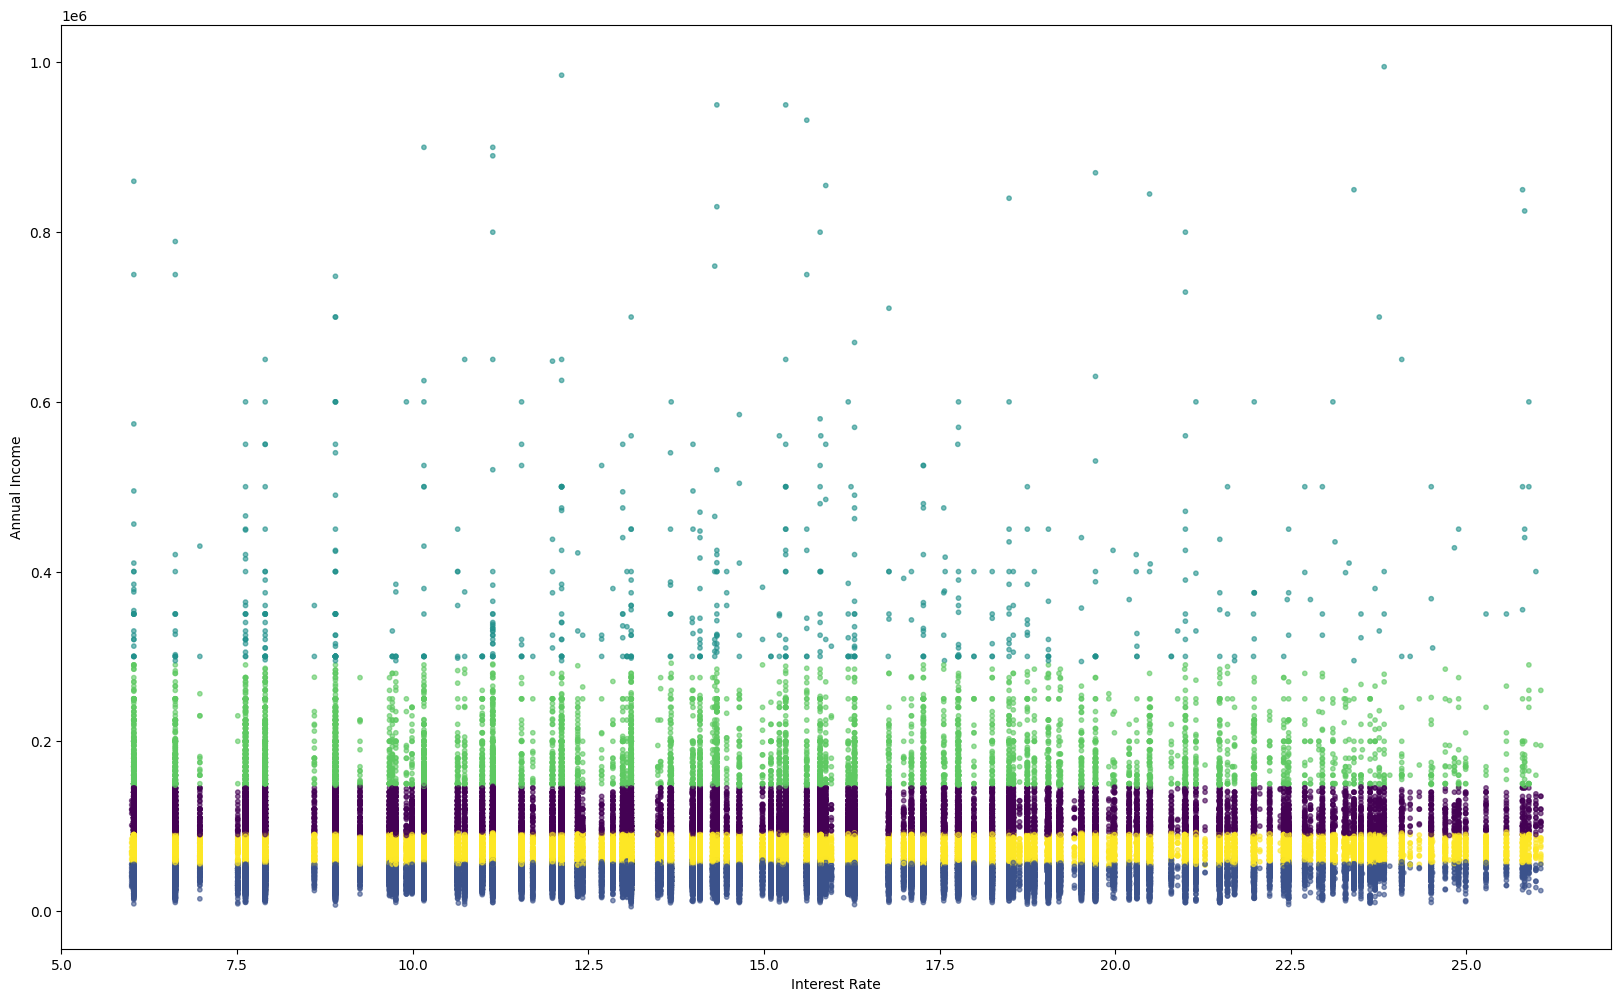

In [57]:
#Plot clusters
plt.figure(figsize=(20,12))
plt.scatter(rescaled_cluster_columns['int_rate'], rescaled_cluster_columns['annual_inc'], c = rescaled_cluster_columns.Cluster, alpha = 0.6, s = 10)
plt.xlabel('Interest Rate')
plt.ylabel('Annual Income')

In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca_scores = pca.fit_transform(cluster_columns)

In [59]:
print("Explained Variance: ")
print(pca.explained_variance_ratio_)
print("Sumn of Explained Variance:")
print(sum(pca.explained_variance_ratio_))

Explained Variance: 
[0.30576961 0.20973273 0.16509484 0.15430788 0.08970392 0.07539101]
Sumn of Explained Variance:
0.9999999999999998


In [60]:
#Clusters and Grades
pd.crosstab(rescaled_cluster_columns['Cluster'],rescaled_cluster_columns.join(loans_analysis['grade'])['grade']).apply(lambda r: (r/r.sum())*100, axis=1)


grade,A,B,C,D,E,F,G
Cluster,,,,,,,
0,13.248313,33.937968,27.505726,15.241751,6.580821,2.897295,0.588126
1,13.690387,33.964891,27.201750,15.619872,6.161420,2.829579,0.532100
2,14.611872,34.474886,25.342466,14.383562,6.392694,4.109589,0.684932
3,14.509899,33.051666,27.836794,15.596330,5.890874,2.390150,0.724288
4,14.049226,34.420459,26.835797,15.082044,5.859420,3.179914,0.573141


In [61]:
pca_out = PCA().fit(cluster_columns)
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = cluster_columns.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6
variable,,,,,,
int_rate,0.092385,-0.520131,0.599631,-0.490449,0.347531,-0.007277
annual_inc,0.552803,0.374764,0.122551,-0.001900,0.214505,0.702087
loan_amnt,0.581264,-0.077114,0.224246,-0.056743,-0.741722,-0.229189
emp_length,0.207462,-0.110823,-0.692965,-0.681309,0.013371,0.010836
dti,0.021624,-0.743101,-0.243095,0.379174,-0.153525,0.469995
revol_bal,0.551814,-0.136339,-0.189319,0.385074,0.509224,-0.483198


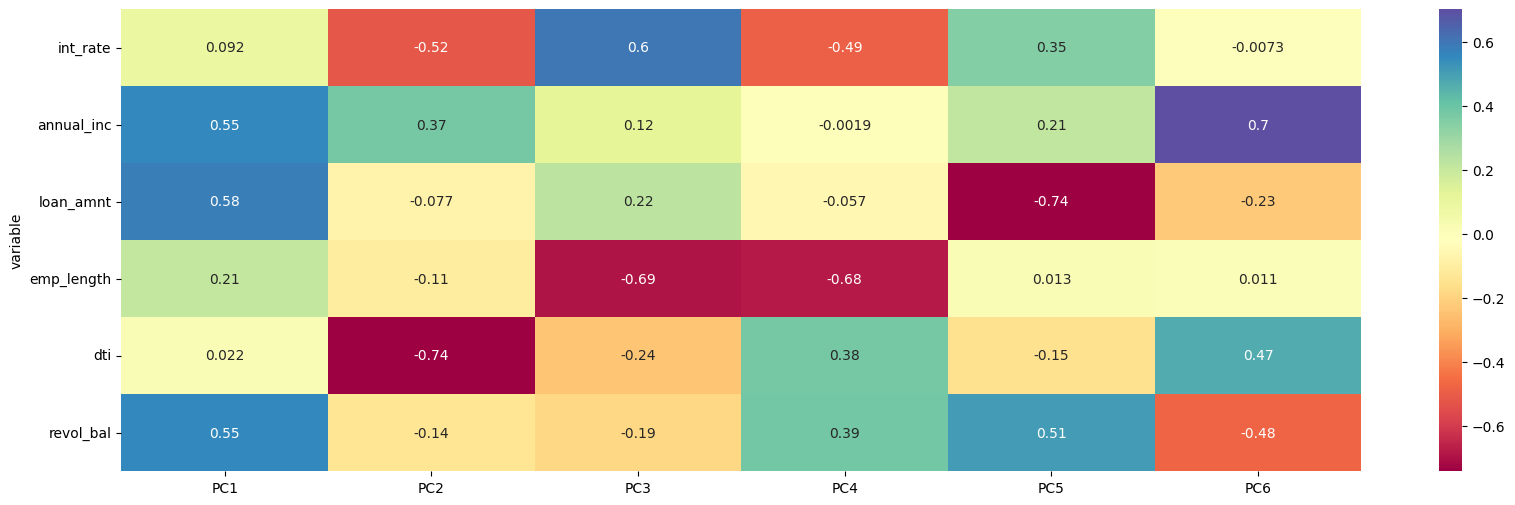

In [62]:
plt.figure(figsize=(20,6))
ax = sn.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

In [63]:
loans_final.describe()

,id,loan_amnt,funded_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,pub_rec,revol_bal,revol_util,total_pymnt,recoveries,total_rec_late_fee,open_acc,total_acc,out_prncp,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
count,1.395080e+05,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000,139508.000000
mean,4.372180e+06,13941.132408,13938.159281,14.067557,440.642026,5.979901,72251.513112,16.802672,0.229005,0.097822,15632.812771,58.020997,14922.754109,193.621815,0.779341,10.980847,24.566484,0.836591,22.446169,40.237520,2.474673,6.207992,2.546680,4.214915,7.278764
std,2.674021e+06,7955.183935,7952.238795,4.380959,244.423961,3.563556,43644.373040,7.576368,0.680904,0.352311,14314.128308,23.241237,9662.740934,782.277989,5.749355,4.585936,11.137691,87.322523,10.778752,9.151203,7.709578,9.699775,5.516091,5.877024,6.547716
min,5.852400e+04,1000.000000,1000.000000,6.000000,21.620000,0.000000,5000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.690000,0.000000,0.000000,1.000000,2.000000,0.000000,0.919937,36.000000,-33.144685,-33.144685,-19.879995,-19.869010,-19.848464
25%,1.587031e+06,8000.000000,8000.000000,11.140000,266.180000,3.000000,45000.000000,11.080000,0.000000,0.000000,6962.000000,42.000000,7701.149044,0.000000,0.000000,8.000000,16.000000,0.000000,13.963326,36.000000,2.191795,4.928954,2.602562,4.395400,7.647080
50%,3.812343e+06,12000.000000,12000.000000,14.090000,392.630000,6.000000,62400.000000,16.490000,0.000000,0.000000,12092.000000,60.200000,12630.026917,0.000000,0.000000,10.000000,23.000000,0.000000,22.965564,36.000000,4.604474,8.174462,4.046421,5.838304,9.136055
75%,6.542756e+06,19075.000000,19075.000000,17.270000,573.390000,10.000000,87000.000000,22.260000,0.000000,0.000000,20110.250000,76.400000,20192.537519,0.000000,0.000000,14.000000,31.000000,0.000000,32.986304,36.000000,6.755420,11.574388,5.445333,7.299846,10.535362
max,1.023482e+07,35000.000000,35000.000000,26.060000,1408.130000,10.000000,995000.000000,34.990000,18.000000,10.000000,199968.000000,128.100000,57898.139904,29282.070000,220.350000,52.000000,99.000000,17062.010000,52.994928,60.000000,14.658889,96.849776,15.505294,17.435644,20.922295


In [64]:
#Save
#loans_analysis.to_csv('loans_analysis_M2.csv')
#loans_final.to_csv('ret_loans_data_M2.csv')
loans_final_returns = loans_final.copy()


In [65]:
#Module 3

#final_loans = pd.read_csv('loans_data.csv')
final_loans = loans_final_returns.copy()


In [66]:
#Convert dates to numerics
for col in date_columns:
    final_loans[col] = (pd.to_datetime(final_loans[col])-datetime.datetime(1970,1,1)).dt.total_seconds()

In [67]:
final_loans[date_columns]

,issue_d,earliest_cr_line,last_pymnt_d
4,1.385856e+09,8.966592e+08,1.430438e+09
6,1.385856e+09,6.730560e+08,1.404173e+09
7,1.385856e+09,9.072000e+08,1.441066e+09
10,1.385856e+09,1.062374e+09,1.464739e+09
12,1.385856e+09,7.836480e+08,1.406851e+09
...,...,...,...
188115,1.325376e+09,1.091318e+09,1.393632e+09
188117,1.325376e+09,9.860832e+08,1.364774e+09
188118,1.325376e+09,5.916672e+08,1.414800e+09
188119,1.325376e+09,1.072915e+09,1.420070e+09


In [68]:
# emp_length conversion
final_loans.emp_length = final_loans.emp_length.astype(float)
final_loans['emp_length']

4         10.0
6         10.0
7         10.0
10         3.0
12         5.0
          ... 
188115     9.0
188117     3.0
188118     7.0
188119     3.0
188120     3.0
Name: emp_length, Length: 139508, dtype: float64

<AxesSubplot: >

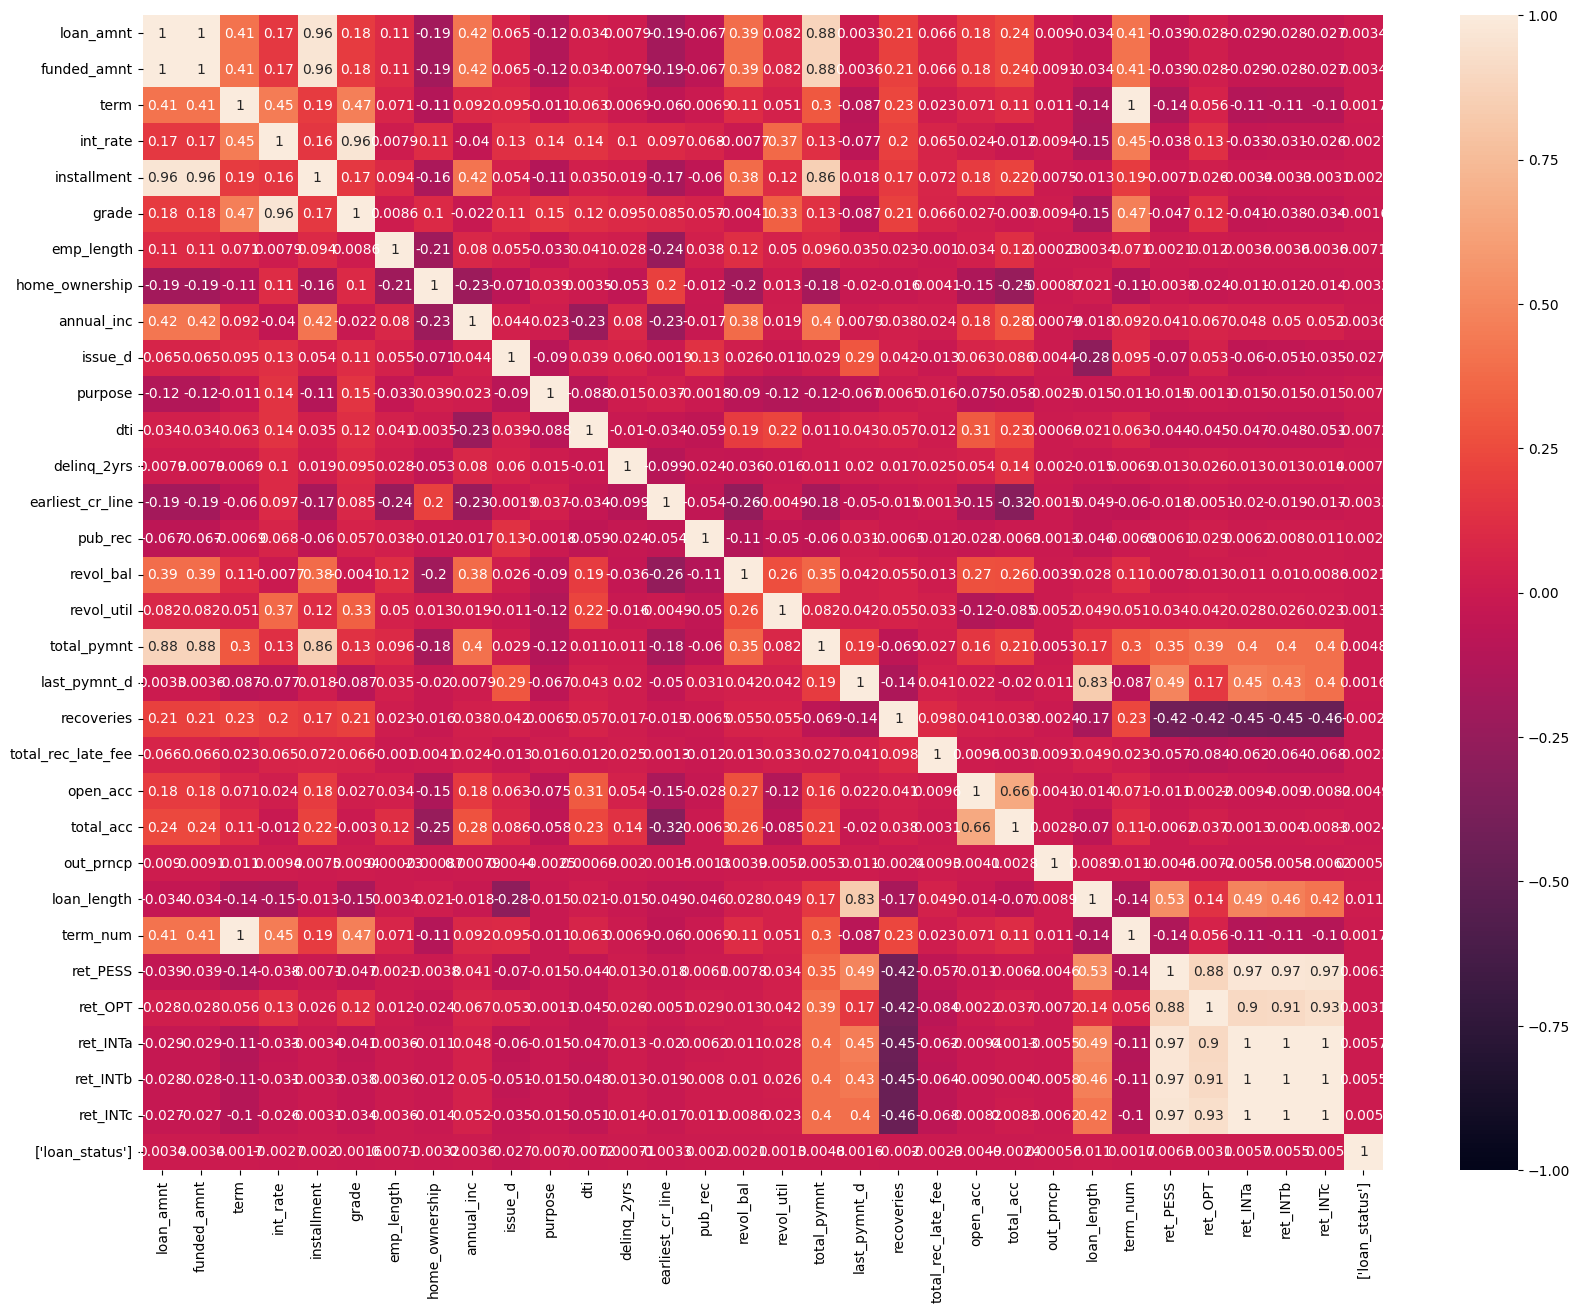

In [69]:
# Correlation with continuous and categorical features against target variable
def correlation_plot(dataframe, columns_left_out, target, target_values):
    
    # Create subset of dataframe only including desired target values
    dataframe_subset = dataframe[dataframe[target[0]].isin(target_values)]
    
    # Collect features and transform to numeric for correlation plot
    drop_columns = list(columns_left_out + target)
    df_features = dataframe_subset.drop(drop_columns, axis=1)
    
    for col,data_type in zip(df_features.columns, df_features.dtypes):
        if data_type == 'object':
            df_features[col] = df_features[col].astype(str)
            df_features[col] = LabelEncoder().fit_transform(df_features[col])
        else:
            continue
        
    # Isolate target variable
    df_target = dataframe_subset[target]
    df_target = pd.DataFrame(LabelEncoder().fit_transform(df_target), columns=[str(target)])
    
    # Join to place target variable at end of dataframe
    df_correlation = df_features.join(df_target)
    
    plt.figure(figsize=(20, 15))
    
    return sns.heatmap(df_correlation.corr(),vmin=-1, vmax=1, annot=True)

correlation_plot(final_loans, ['id'], ['loan_status'], ['Fully Paid', 'Default'])

<AxesSubplot: >

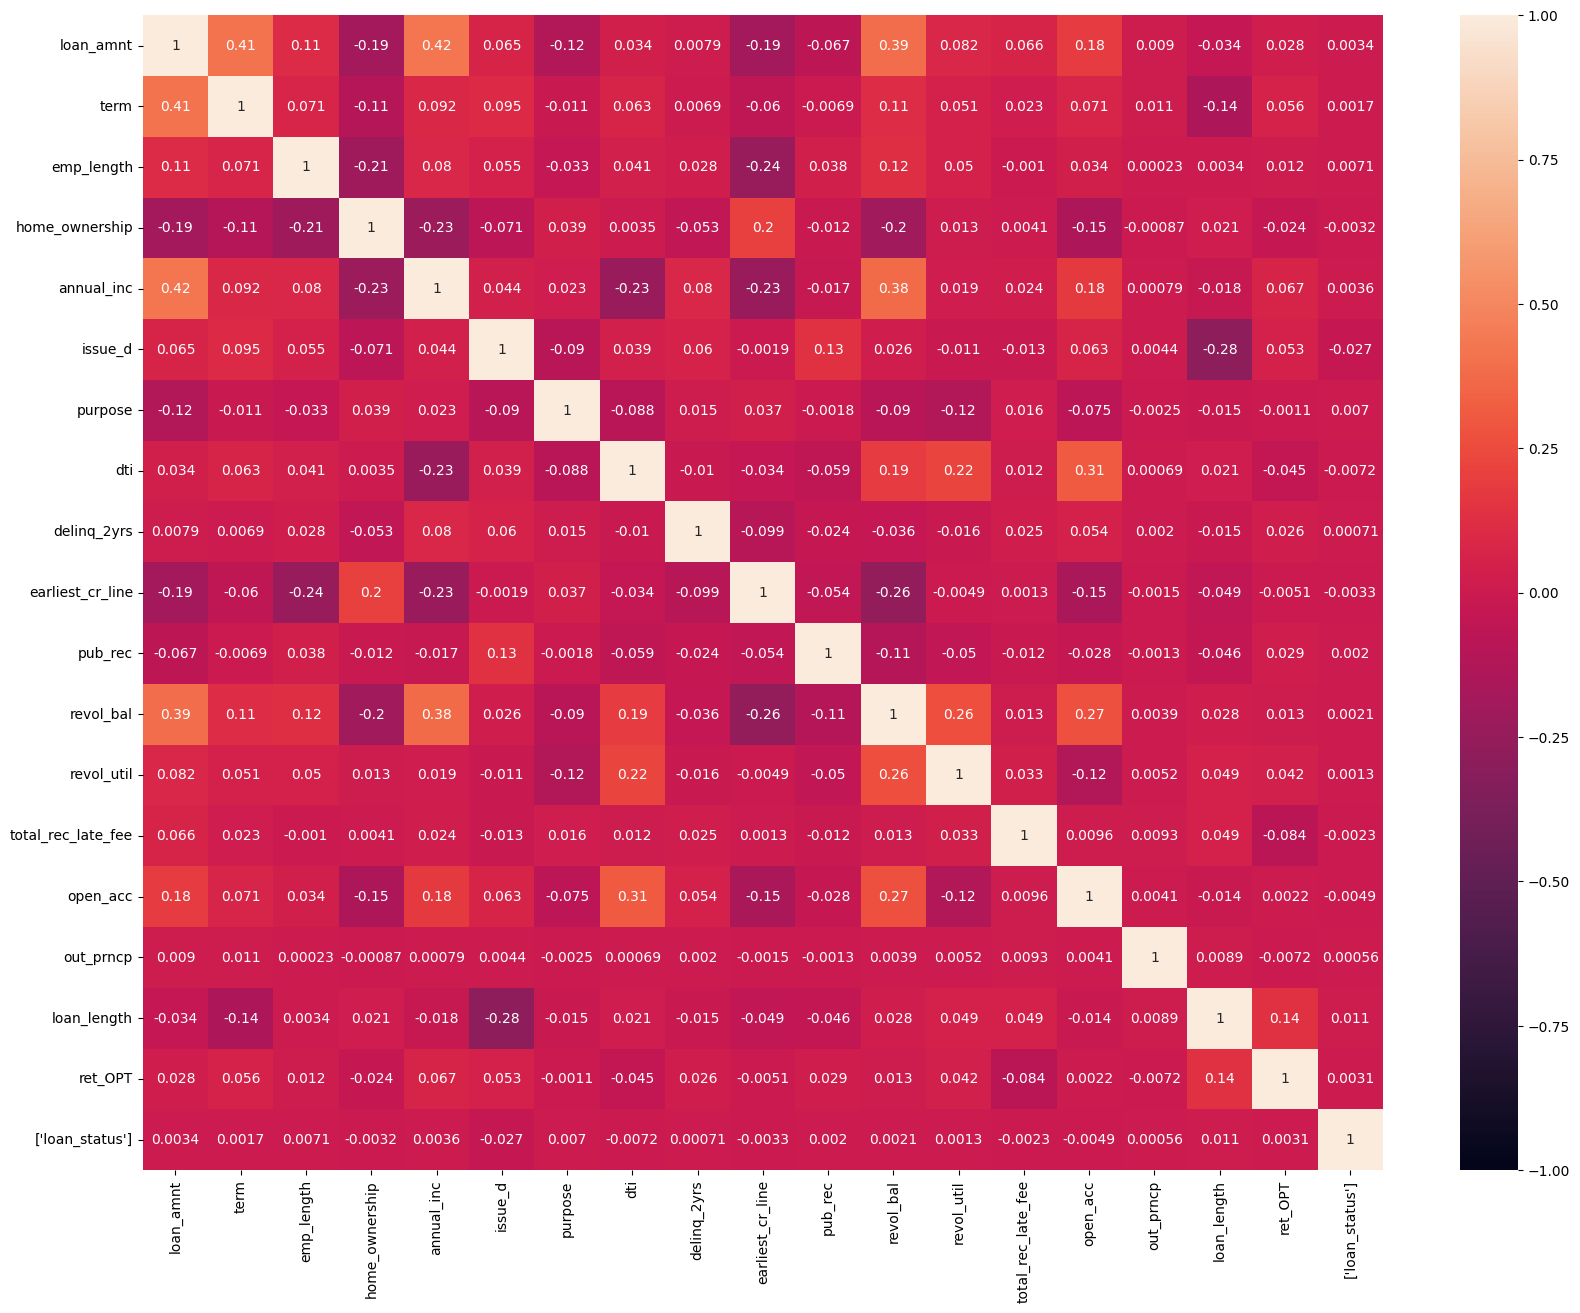

In [70]:
# After running correlation plot, values >0.7 are dropped and correlation is performed again to ensure
# no multicollinearity between variables

dropped_columns = ['funded_amnt', 'installment', 'total_pymnt', 'grade', 'int_rate', 'last_pymnt_d', 'recoveries', 
                   'ret_PESS', 'ret_INTa', 'ret_INTb', 'ret_INTc', 'term_num', 'total_acc']

final_loans_dropped = final_loans.drop(dropped_columns, axis=1)

correlation_plot(final_loans_dropped, ['id'], ['loan_status'], ['Fully Paid', 'Default'])

In [71]:
# Check zeros in columms and drop columns greater than threshold input
def handle_zeros(dataframe_joined, threshold_input):
    
    # View columns with zeros
    zeros_count=pd.DataFrame(round((dataframe_joined==0).astype(int).sum()/dataframe_joined.shape[0]*100,2),columns=['%Zeros'])
    zeros_count.sort_values('%Zeros', ascending=False, inplace=True)
    
    # Drop columns with zeros > threshold_input
    threshold = threshold_input
    for row in zeros_count.iterrows():
        try: 
            if int(row[1]) > threshold:
                dataframe_joined.drop(row[0], inplace=True, axis=1)
        except:
            continue
    
    return zeros_count, dataframe_joined

zeros_count, final_loans_droppped = handle_zeros(final_loans_dropped, 50)

array([[<AxesSubplot: title={'center': 'id'}>,
        <AxesSubplot: title={'center': 'loan_amnt'}>,
        <AxesSubplot: title={'center': 'emp_length'}>],
       [<AxesSubplot: title={'center': 'annual_inc'}>,
        <AxesSubplot: title={'center': 'issue_d'}>,
        <AxesSubplot: title={'center': 'dti'}>],
       [<AxesSubplot: title={'center': 'earliest_cr_line'}>,
        <AxesSubplot: title={'center': 'revol_bal'}>,
        <AxesSubplot: title={'center': 'revol_util'}>],
       [<AxesSubplot: title={'center': 'open_acc'}>,
        <AxesSubplot: title={'center': 'loan_length'}>,
        <AxesSubplot: title={'center': 'ret_OPT'}>]], dtype=object)

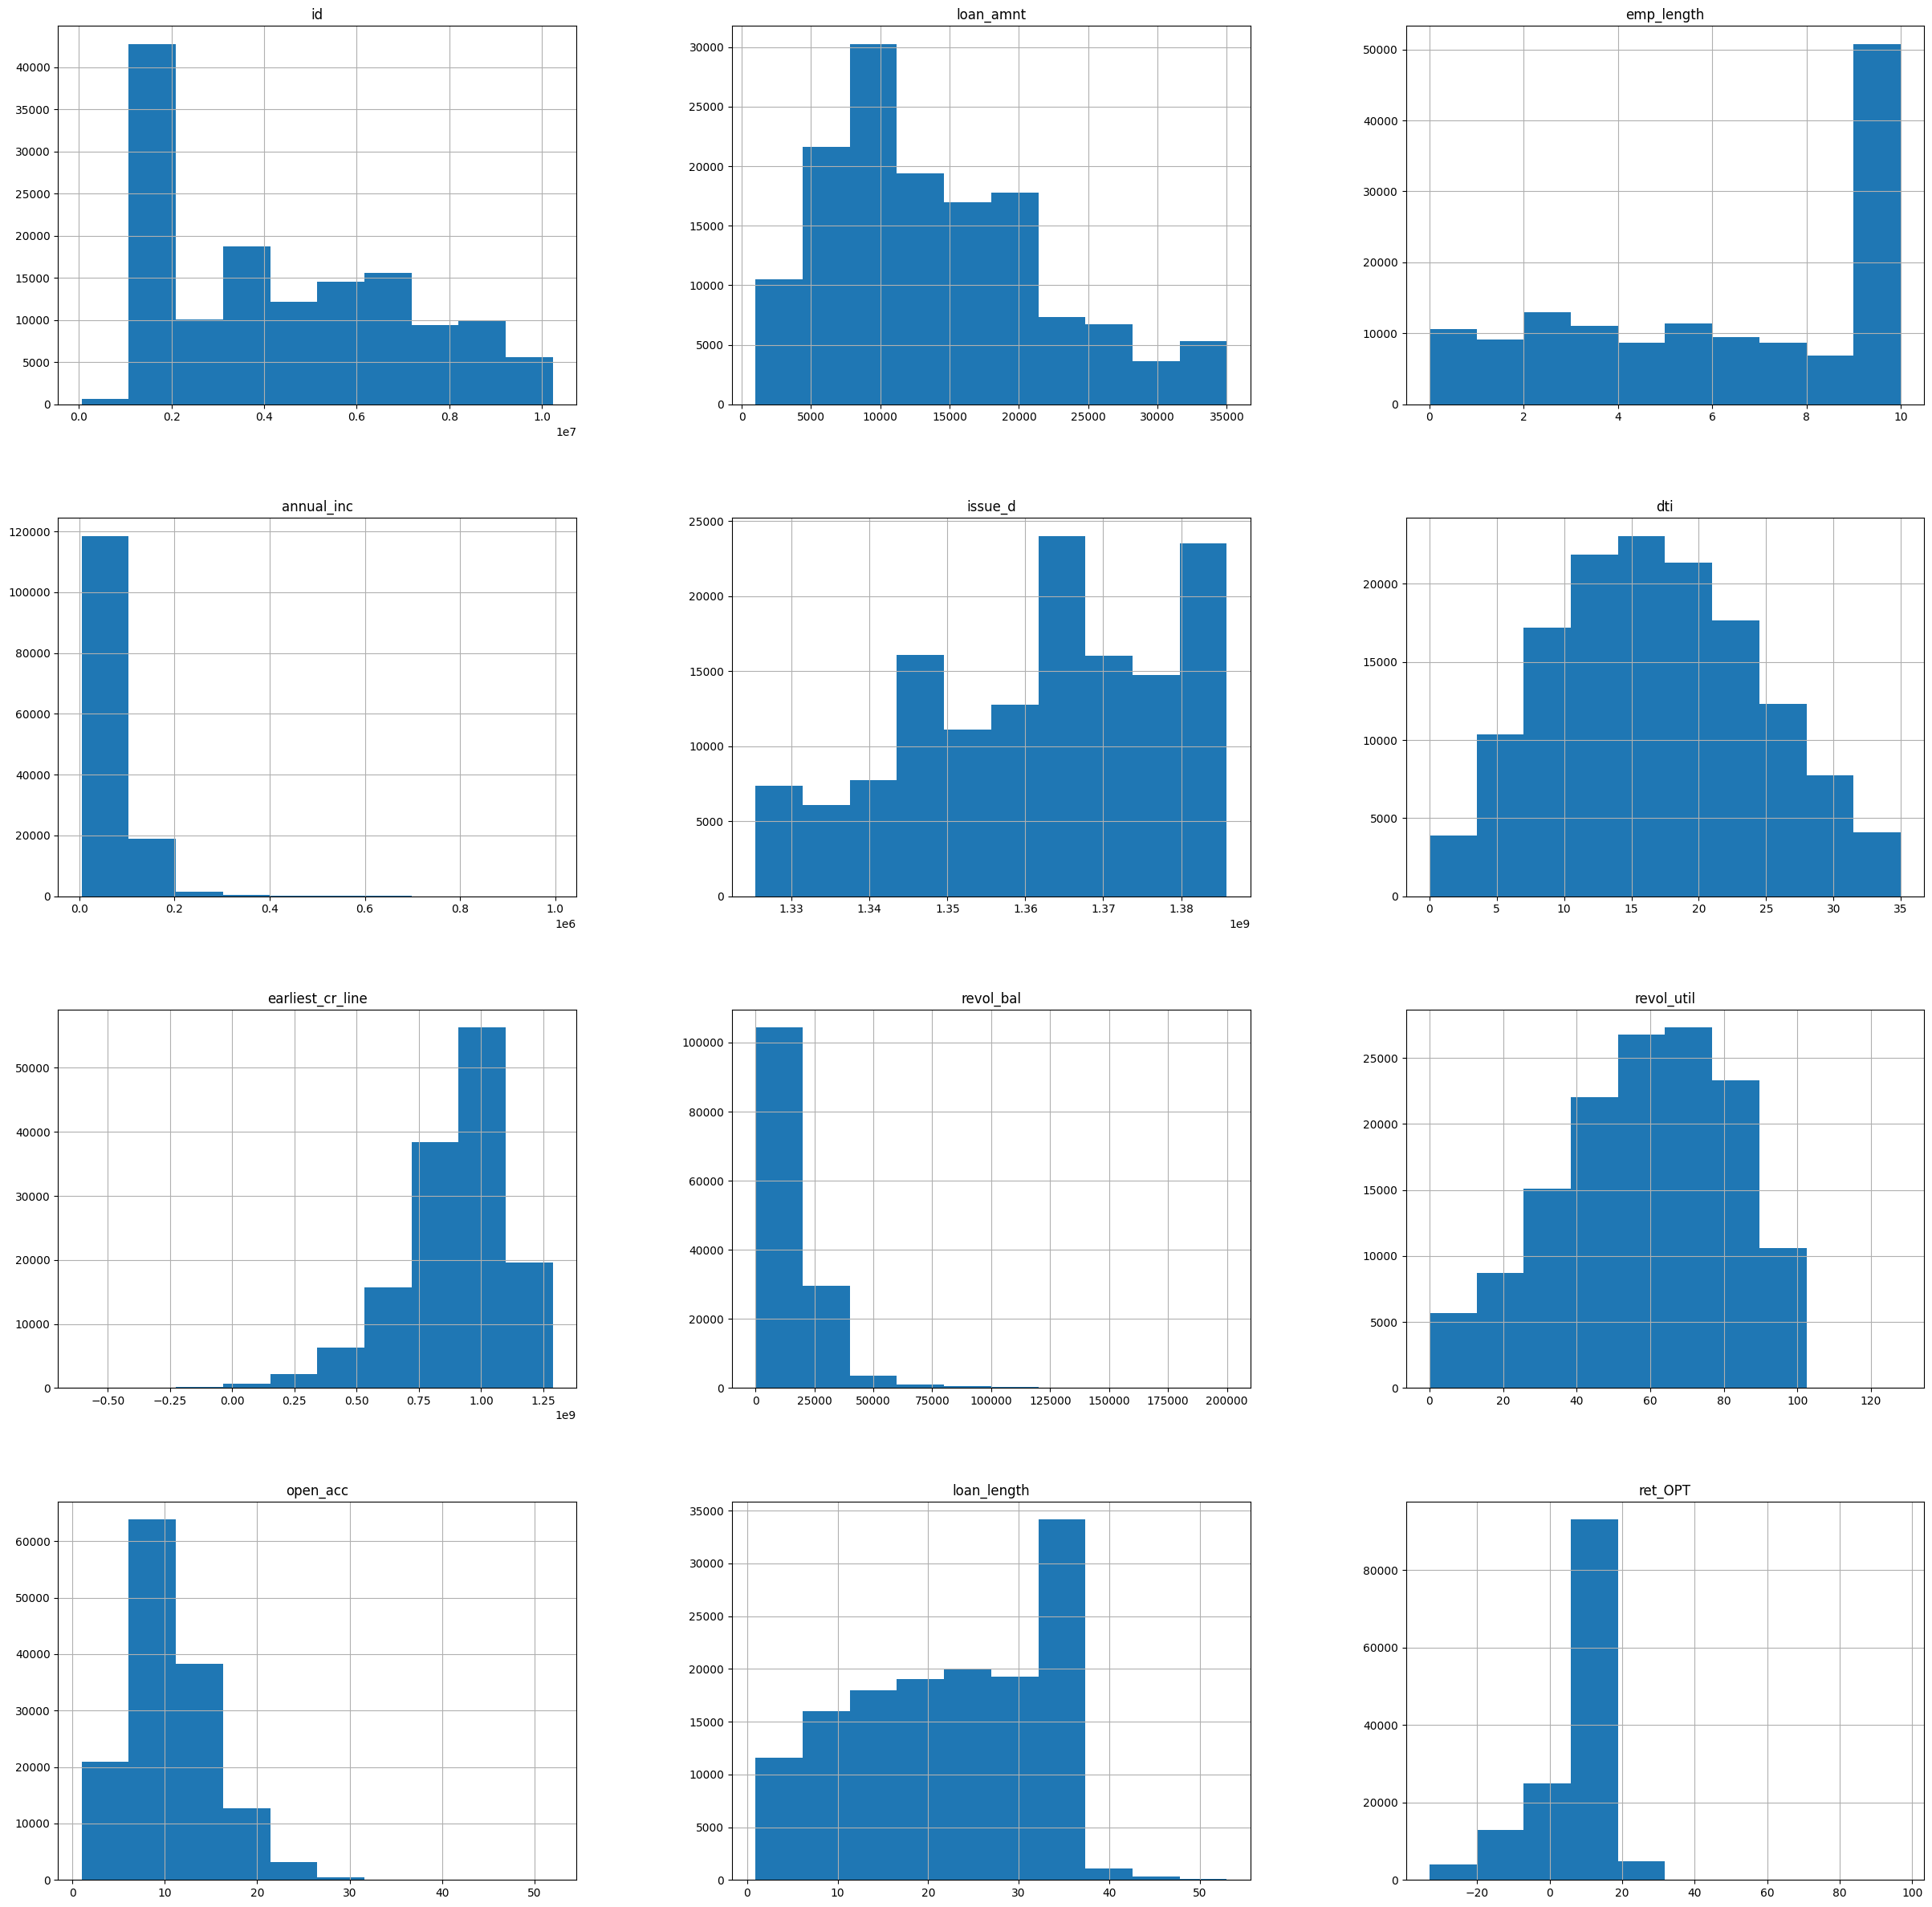

In [72]:
# Check data transformations
final_loans_dropped.hist(figsize=(30,30))

In [73]:
# Log normal transformations
trans_list = ['annual_inc', 'revol_bal']

final_loans_dropped_T = final_loans_dropped.copy()

for item in trans_list:
    final_loans_dropped_T[item] = np.log(final_loans_dropped_T[item]).clip(lower=0)

array([[<AxesSubplot: title={'center': 'id'}>,
        <AxesSubplot: title={'center': 'loan_amnt'}>,
        <AxesSubplot: title={'center': 'emp_length'}>],
       [<AxesSubplot: title={'center': 'annual_inc'}>,
        <AxesSubplot: title={'center': 'issue_d'}>,
        <AxesSubplot: title={'center': 'dti'}>],
       [<AxesSubplot: title={'center': 'earliest_cr_line'}>,
        <AxesSubplot: title={'center': 'revol_bal'}>,
        <AxesSubplot: title={'center': 'revol_util'}>],
       [<AxesSubplot: title={'center': 'open_acc'}>,
        <AxesSubplot: title={'center': 'loan_length'}>,
        <AxesSubplot: title={'center': 'ret_OPT'}>]], dtype=object)

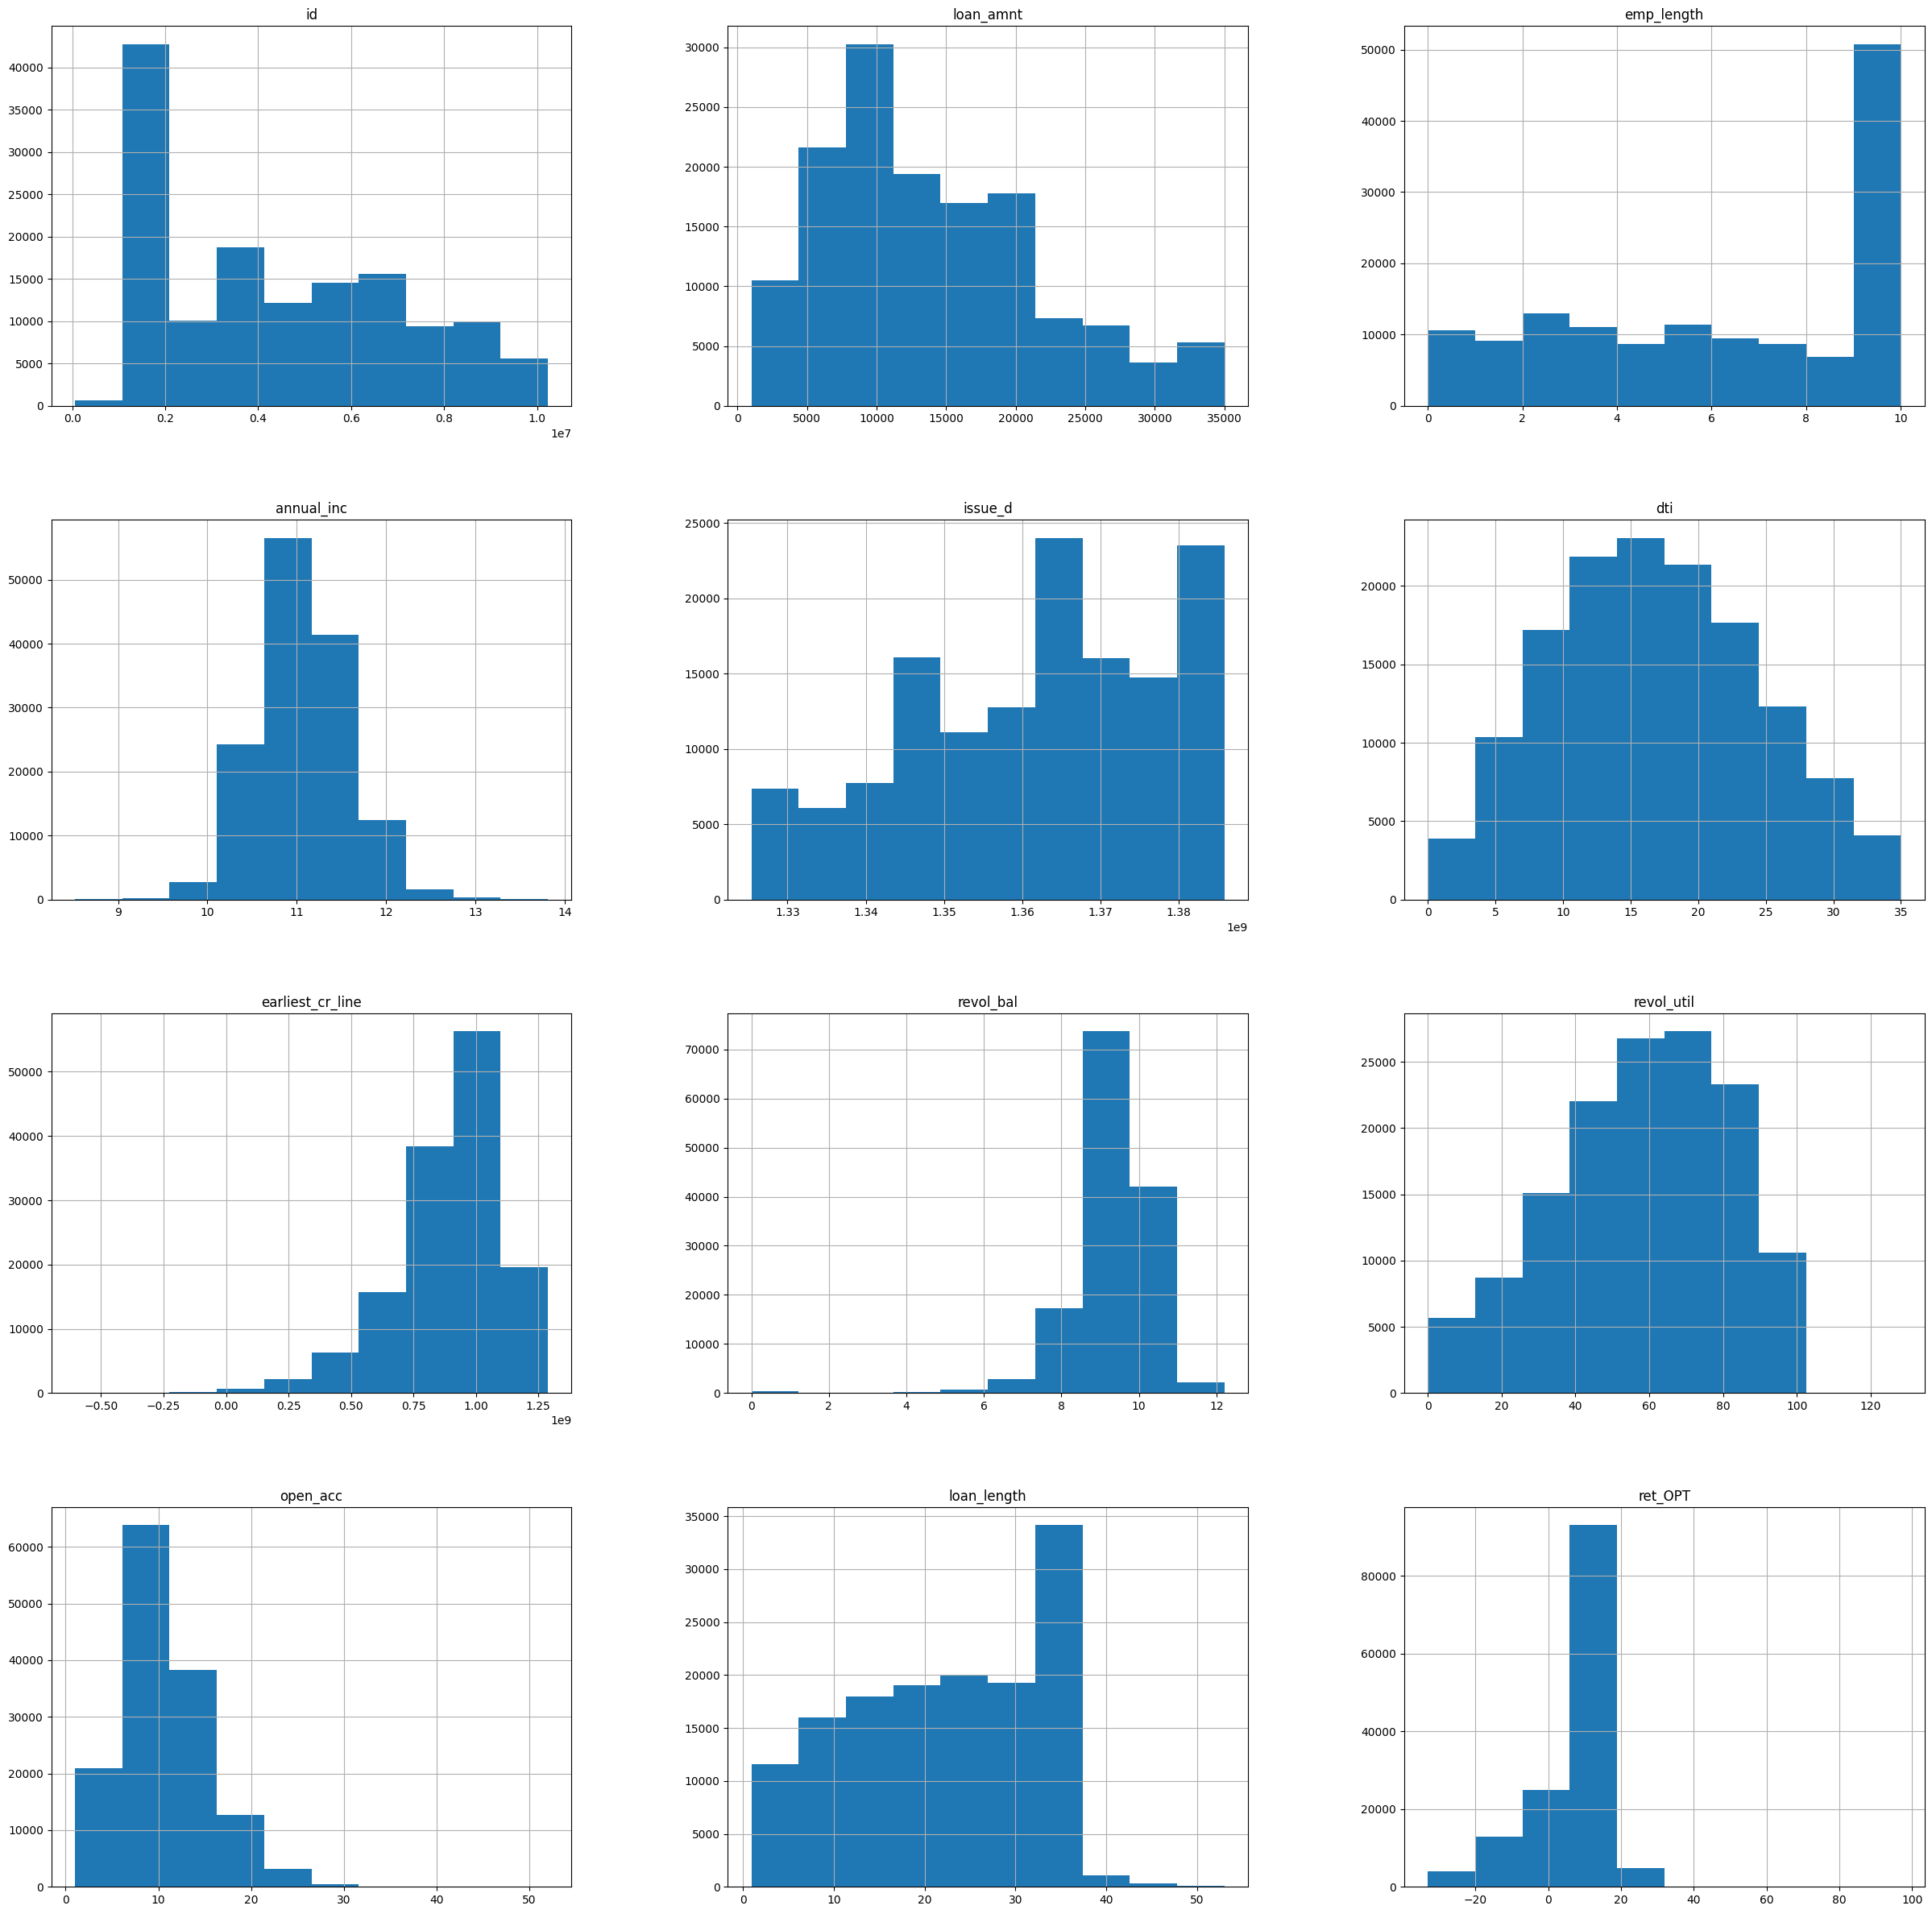

In [74]:
# Check data after transformation
final_loans_dropped_T.hist(figsize=(30,30))

In [75]:
final_loans_dropped_T = final_loans_dropped_T[(final_loans_dropped_T['home_ownership'] != 'NONE') & 
                                              (final_loans_dropped_T['home_ownership'] != 'OTHER')]

In [76]:
# Downsample data set
def downsample_split_binary(dataframe, columns_left_out, target, target_values):
    
    ## DOWNSAMPLE
    
    # Split dataframes by their target values
    temp_target_1 = dataframe[dataframe[target[0]] == target_values[0]]
    temp_target_2 = dataframe[dataframe[target[0]] == target_values[1]]
    print(temp_target_1.shape)
    print(temp_target_2.shape)
    
    # Checks which dataframe above needs downsampled
    if temp_target_1.shape[0] > temp_target_2.shape[0]:
        
        downsample_amount = temp_target_2.shape[0]
        
        # Resamples data and merges dataframes
        temp_target_1 = resample(temp_target_1, replace=True, n_samples=downsample_amount, random_state=42)
        df_downsampled = pd.concat([temp_target_1, temp_target_2], ignore_index=False, sort=False)
        
    else:
        
        downsample_amount = temp_target_1.shape[0]
        
        # Resamples data and merges dataframes
        temp_target_2 = resample(temp_target_2, replace=True, n_samples=downsample_amount, random_state=42)
        df_downsampled = pd.concat([temp_target_2, temp_target_1], ignore_index=False, sort=False)
      
    
    ## SPLIT DATA
    
    # Split data into train and test sets
    drop_columns = list(columns_left_out + target)
    df_x = df_downsampled.drop(drop_columns, axis=1)
    df_y = df_downsampled[target]
    
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)
    
    return df_downsampled, df_x, df_y, x_train, x_test, y_train, y_test

final_loans_dropped.head()

df_downsampled, df_x, df_y, x_train, x_test, y_train, y_test = downsample_split_binary(final_loans_dropped_T, 
                                                                                       ['id', 'ret_OPT', 'loan_length'], 
                                                                                       ['loan_status'], 
                                                                                       ['Fully Paid', 'Default'])

(115357, 16)
(24072, 16)


In [77]:
final_loans_dropped_T.home_ownership.value_counts()

MORTGAGE    70274
RENT        58425
OWN         10730
Name: home_ownership, dtype: int64

In [78]:
# Training / test data list
train_test_features_list = [x_train, x_test]
train_test_target_list   = [y_train, y_test]

# Scale float data
for dataframe in train_test_features_list:
    numeric_list = dataframe.columns[dataframe.dtypes == 'float64'].to_list()
    dataframe[numeric_list] = StandardScaler().fit_transform(dataframe[numeric_list])

# Categorical one-hot encoding coversion

updated_features_dict = {}
count=0
for dataframe in train_test_features_list:
    categorical_list = dataframe.columns[dataframe.dtypes == 'object'].to_list()
    
    one_hot_df = pd.DataFrame()
    
    for item in categorical_list:
        one_hot = pd.get_dummies(dataframe[item])
        one_hot_df = pd.concat([one_hot_df,one_hot], axis=1)
        
    dataframe.drop(categorical_list, axis=1, inplace=True)
    updated_features_dict[count] = pd.concat([dataframe, one_hot_df], axis=1)
    count+=1
    
x_train = updated_features_dict[0]
x_test = updated_features_dict[1]

# loan_status conversion
for dataframe in train_test_target_list:
    dataframe.replace('Default', 0, inplace = True)
    dataframe.replace('Fully Paid', 1, inplace = True)

In [79]:
# Determine probability of default for each loan

# Runs Logistic Regression
model_logistic = LogisticRegression().fit(x_train, y_train)

# Training data
r2_train = model_logistic.score(x_train, y_train)
pred_train = model_logistic.predict(x_train)
mse_train = metrics.mean_squared_error(y_train, pred_train)
print('MSE training set =', round(mse_train, 5), '& R^2 =', round(r2_train, 5))

# Test data
r2_test = model_logistic.score(x_test, y_test)
pred = model_logistic.predict(x_test)
mse_test = metrics.mean_squared_error(y_test, pred)
print('MSE test set =', round(mse_test, 5), '& R^2 =', round(r2_test, 5))

MSE training set = 0.37122 & R^2 = 0.62878
MSE test set = 0.37102 & R^2 = 0.62898


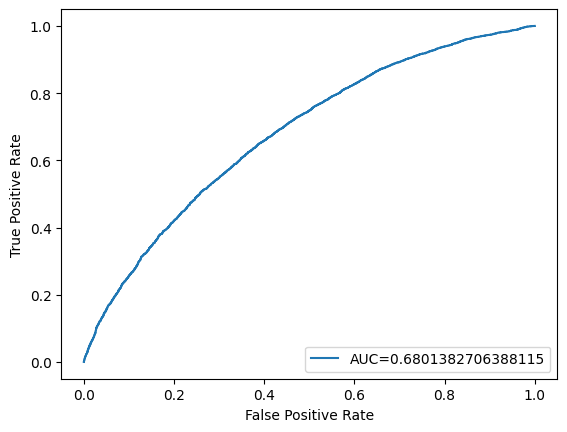

In [80]:
#create ROC curve
y_pred = LogisticRegression().fit(x_train, y_train).predict_proba(x_test)[:,1] 
auc = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [81]:
# Decision Trees
final_loans_dropped = final_loans_dropped[(final_loans_dropped['home_ownership'] != 'NONE') & 
                                              (final_loans_dropped['home_ownership'] != 'OTHER')]

In [82]:
# Preprocess data since decision tree requires no normalization

df_downsampled, df_x, df_y, x_train, x_test, y_train, y_test = downsample_split_binary(final_loans_dropped, 
                                                                                       ['id', 'ret_OPT', 'loan_length'], 
                                                                                       ['loan_status'], 
                                                                                       ['Fully Paid', 'Default'])
# Training / test data list
train_test_features_list = [x_train, x_test]
train_test_target_list   = [y_train, y_test]

# Categorical one-hot encoding coversion

updated_features_dict = {}
count=0
for dataframe in train_test_features_list:
    categorical_list = dataframe.columns[dataframe.dtypes == 'object'].to_list()
    
    one_hot_df = pd.DataFrame()
    
    for item in categorical_list:
        one_hot = pd.get_dummies(dataframe[item])
        one_hot_df = pd.concat([one_hot_df,one_hot], axis=1)
        
    dataframe.drop(categorical_list, axis=1, inplace=True)
    updated_features_dict[count] = pd.concat([dataframe, one_hot_df], axis=1)
    count+=1
    
x_train = updated_features_dict[0]
x_test = updated_features_dict[1]

# loan_status conversion
for dataframe in train_test_target_list:
    dataframe.replace('Default', 0, inplace = True)
    dataframe.replace('Fully Paid', 1, inplace = True)

(115357, 16)
(24072, 16)


In [83]:
lst_train = []
lst_test = []
for x in range(1,11):
    # Decision Tree setup
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=x).fit(x_train, y_train)

    # Training data
    r2_train = dtree.score(x_train, y_train)
    pred_train = dtree.predict(x_train)
    mse_train = metrics.mean_squared_error(y_train, pred_train)
    #print('MSE training set =', round(mse_train, 5), '& R^2 =', round(r2_train, 5))
    train_lst = [x,round(mse_train, 5),round(r2_train, 5)]
    lst_train.append(train_lst)
                                        
                 
    
    # Test data
    r2_test = dtree.score(x_test, y_test)
    pred = dtree.predict(x_test)
    mse_test = metrics.mean_squared_error(y_test, pred)
    #print('MSE test set =', round(mse_test, 5), '& R^2 =', round(r2_test, 5))
    test_lst = [x,round(mse_test, 5),round(r2_test, 5)]
    lst_test.append(test_lst)
    

results_train = pd.DataFrame(lst_train, columns = ['Depth', 'MSE', 'R^2'])
results_test = pd.DataFrame(lst_test, columns = ['Depth', 'MSE', 'R^2'])


In [84]:
results_train

,Depth,MSE,R^2
0,1,0.40490,0.59510
1,2,0.40490,0.59510
2,3,0.39000,0.61000
3,4,0.38988,0.61012
4,5,0.38131,0.61869
5,6,0.37424,0.62576
6,7,0.36626,0.63374
7,8,0.35579,0.64421
8,9,0.34570,0.65430
9,10,0.33003,0.66997


In [85]:
results_test

,Depth,MSE,R^2
0,1,0.40370,0.59630
1,2,0.40370,0.59630
2,3,0.39864,0.60136
3,4,0.39885,0.60115
4,5,0.39449,0.60551
5,6,0.38964,0.61036
6,7,0.38895,0.61105
7,8,0.38480,0.61520
8,9,0.39234,0.60766
9,10,0.39525,0.60475


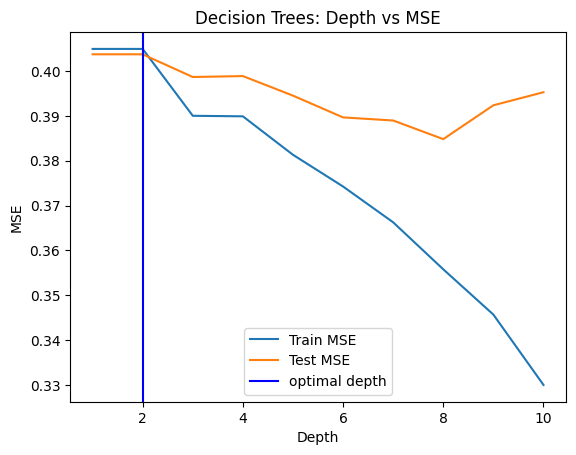

In [86]:
#Plot train MSE vs test MSE
plt.plot(results_train['Depth'], results_train['MSE'], label = 'Train MSE')
plt.plot(results_test['Depth'], results_test['MSE'], label = 'Test MSE')
plt.xlabel('Depth')
plt.ylabel('MSE')
plt.title ('Decision Trees: Depth vs MSE')
plt.axvline(x=2, color='b', label = 'optimal depth')
plt.legend()
plt.show()

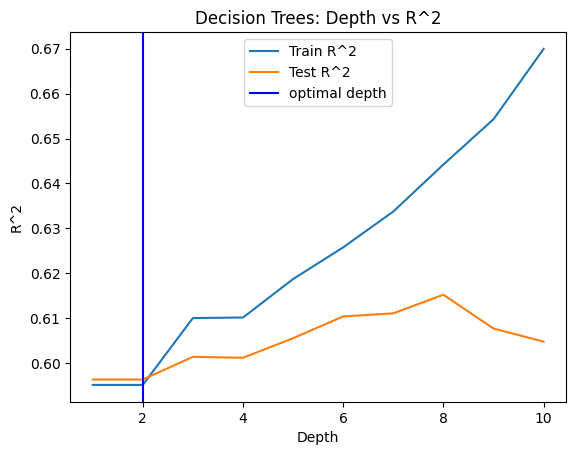

In [87]:
#Plot train MSE vs test MSE
plt.plot(results_train['Depth'], results_train['R^2'], label = 'Train R^2')
plt.plot(results_test['Depth'], results_test['R^2'], label = 'Test R^2')
plt.xlabel('Depth')
plt.ylabel('R^2')
plt.title ('Decision Trees: Depth vs R^2')
plt.axvline(x=2, color='b', label = 'optimal depth')
plt.legend()
plt.show()

MSE training set = 0.4049 & R^2 = 0.5951
MSE test set = 0.4037 & R^2 = 0.5963


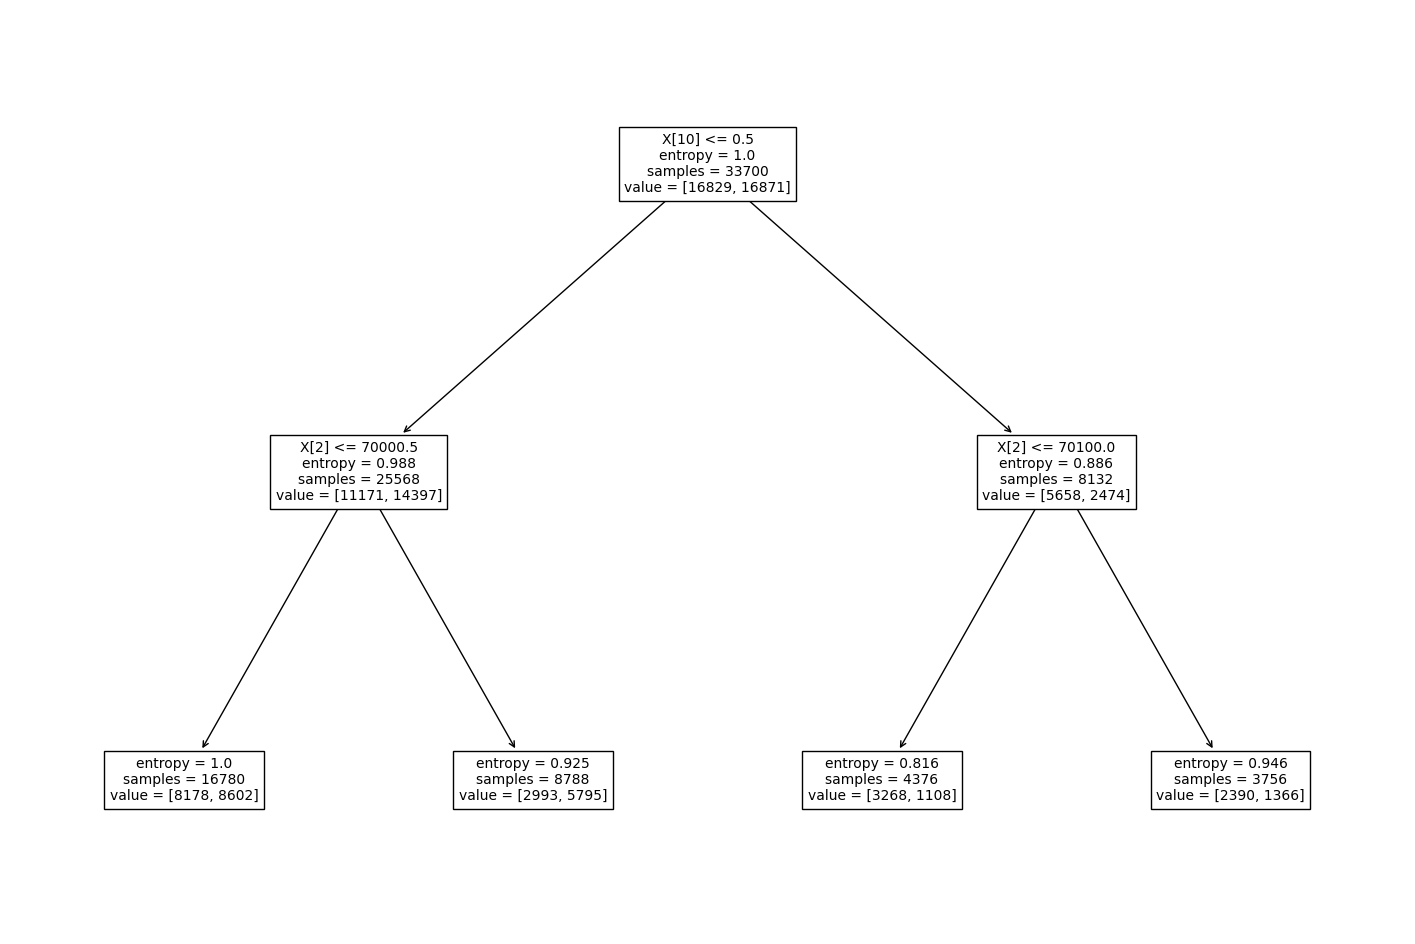

In [88]:
# Decision Tree

# Decision Tree setup
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=2).fit(x_train, y_train)

# Training data
r2_train = dtree.score(x_train, y_train)
pred_train = dtree.predict(x_train)
mse_train = metrics.mean_squared_error(y_train, pred_train)
print('MSE training set =', round(mse_train, 5), '& R^2 =', round(r2_train, 5))

# Test data
r2_test = dtree.score(x_test, y_test)
pred = dtree.predict(x_test)
mse_test = metrics.mean_squared_error(y_test, pred)
print('MSE test set =', round(mse_test, 5), '& R^2 =', round(r2_test, 5))


plt.figure(figsize=(18,12))  # set plot size (denoted in inches)
tree.plot_tree(dtree, fontsize=10)
plt.show()


In [89]:
#Module 4

#Step 1:  Predicting returns and picking loans using heuristics

# Start by reading the saved data from the second module
# df = pd.read_csv('ret_loans_data_M2.csv')
df = final_loans_dropped_T.copy()

In [90]:
# Add credit history and default columns
# df['cr_hist'] = (df['issue_d'] - df['earliest_cr_line'])
#df['cr_hist'] = df['cr_hist'] / np.timedelta64(1,'D')

In [91]:
# Return method = Optimistic
ret_col = "ret_OPT"

In [92]:
dropped_lin = ['id','loan_length', 'ret_OPT', 'loan_status' ]

In [93]:
df_x_lin = df.drop(dropped_lin, axis = 1)
df_y_lin = df[ret_col] / 100
df_y_lin

4         0.106401
6         0.104260
7         0.064769
10        0.046590
12        0.061785
            ...   
188115    0.103403
188117    0.068297
188118    0.097715
188119    0.084217
188120    0.090862
Name: ret_OPT, Length: 139429, dtype: float64

In [94]:
#divide data
x_train_lin, x_test_lin, y_train_lin, y_test_lin = train_test_split(df_x_lin, df_y_lin, test_size=0.3, random_state=42)

# Training / test data list
train_test_features_list = [x_train_lin, x_test_lin]
train_test_target_list   = [y_train_lin, y_test_lin]


# Categorical one-hot encoding coversion

updated_features_dict = {}
count=0
for dataframe in train_test_features_list:
    categorical_list = dataframe.columns[dataframe.dtypes == 'object'].to_list()
    
    one_hot_df = pd.DataFrame()
    
    for item in categorical_list:
        one_hot = pd.get_dummies(dataframe[item])
        one_hot_df = pd.concat([one_hot_df,one_hot], axis=1)
        
    dataframe.drop(categorical_list, axis=1, inplace=True)
    updated_features_dict[count] = pd.concat([dataframe, one_hot_df], axis=1)
    count+=1
    
x_train_lin = updated_features_dict[0]
x_test_lin = updated_features_dict[1]

In [95]:
# Linear Regression
model_linear = LinearRegression().fit(x_train_lin, y_train_lin)

# Training data
r2_train = model_linear.score(x_train_lin, y_train_lin)
pred_train = model_linear.predict(x_train_lin)
mse_train = metrics.mean_squared_error(y_train_lin, pred_train)
print('MSE training set =', round(mse_train, 5), '& R^2 =', round(r2_train, 5))

# Test data
r2_test = model_linear.score(x_test_lin, y_test_lin)
pred = model_linear.predict(x_test_lin)
mse_test = metrics.mean_squared_error(y_test_lin, pred)
print('MSE test set =', round(mse_test, 5), '& R^2 =', round(r2_test, 5))

MSE training set = 0.00927 & R^2 = 0.01635
MSE test set = 0.00922 & R^2 = 0.01668


In [96]:
# Lasso Regression
model_lasso = Lasso(alpha=1.0)
model_lasso.fit(x_train_lin, y_train_lin)

# Training data
r2_train = model_lasso.score(x_train_lin, y_train_lin)
pred_train = model_lasso.predict(x_train_lin)
mse_train = metrics.mean_squared_error(y_train_lin, pred_train)
print('MSE training set =', round(mse_train, 5), '& R^2 =', round(r2_train, 5))

# Test data
r2_test = model_lasso.score(x_test_lin, y_test_lin)
pred = model_lasso.predict(x_test_lin)
mse_test = metrics.mean_squared_error(y_test_lin, pred)
print('MSE test set =', round(mse_test, 5), '& R^2 =', round(r2_test, 5))

MSE training set = 0.00939 & R^2 = 0.00301
MSE test set = 0.00934 & R^2 = 0.0041


In [97]:
# Optimal alpha

# Lasso with 10 fold cross-validation
model_lasso = LassoCV(cv=10, random_state=0, max_iter=10000)

# Fit model
model_lasso.fit(x_train_lin, y_train_lin)

round(model_lasso.alpha_, 3)

133.119

In [98]:
# Evaluating with optimal alpha
model_lasso = Lasso(alpha=211)
model_lasso.fit(x_train_lin, y_train_lin)

# Training data
r2_train = model_lasso.score(x_train_lin, y_train_lin)
pred_train = model_lasso.predict(x_train_lin)
mse_train = metrics.mean_squared_error(y_train_lin, pred_train)
print('MSE training set =', round(mse_train, 5), '& R^2 =', round(r2_train, 5))

# Test data
r2_test = model_lasso.score(x_test_lin, y_test_lin)
pred = model_lasso.predict(x_test_lin)
mse_test = metrics.mean_squared_error(y_test_lin, pred)
print('MSE test set =', round(mse_test, 5), '& R^2 =', round(r2_test, 5))

MSE training set = 0.0094 & R^2 = 0.00248
MSE test set = 0.00935 & R^2 = 0.00345


In [99]:
# Ridge Regression
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(x_train_lin, y_train_lin)

# Training data
r2_train = model_ridge.score(x_train_lin, y_train_lin)
pred_train = model_ridge.predict(x_train_lin)
mse_train = metrics.mean_squared_error(y_train_lin, pred_train)
print('MSE training set =', round(mse_train, 5), '& R^2 =', round(r2_train, 5))

# Test data
r2_test = model_ridge.score(x_test_lin, y_test_lin)
pred = model_ridge.predict(x_test_lin)
mse_test = metrics.mean_squared_error(y_test_lin, pred)
print('MSE test set =', round(mse_test, 5), '& R^2 =', round(r2_test, 5))

# Ridge with 10 fold cross-validation
# model = RidgeCV(cv=10, random_state=0, max_iter=10000)

# # Fit model
# model.fit(x_train, y_train)

# round(model.alpha_, 3)

MSE training set = 0.00927 & R^2 = 0.01635
MSE test set = 0.00922 & R^2 = 0.01669


In [100]:
df_x_lin_temp = df_x_lin.copy()

# Add that as a column prob_default
value_df = df[['id', 'loan_amnt', 'term', ret_col]]

# Scale float data
numeric_list = df_x_lin_temp.columns[df_x_lin_temp.dtypes == 'float64'].to_list()
df_x_lin_temp[numeric_list] = StandardScaler().fit_transform(df_x_lin_temp[numeric_list])

# Categorical one-hot encoding coversion
updated_features_dict = {}
count=0
categorical_list = df_x_lin_temp.columns[df_x_lin_temp.dtypes == 'object'].to_list()

one_hot_df = pd.DataFrame()

for item in categorical_list:
    one_hot = pd.get_dummies(df_x_lin_temp[item])
    one_hot_df = pd.concat([one_hot_df,one_hot], axis=1)

df_x_lin_temp = df_x_lin_temp.drop(categorical_list, axis=1)
df_x_lin_temp = pd.concat([df_x_lin_temp, one_hot_df], axis=1)

pred = model_logistic.predict_proba(df_x_lin_temp)[:, 1]
pred_return = model_linear.predict(df_x_lin_temp)
value_df['prob_default'] = pred
value_df['pred_return'] = pred_return
value_df['expected_return'] = value_df['prob_default'] * value_df['ret_OPT']

In [101]:
value_df

,id,loan_amnt,term,ret_OPT,prob_default,pred_return,expected_return
4,10129506,20800.0,36 months,10.640111,0.407877,-0.435338,4.339854
6,10179520,3000.0,36 months,10.426003,0.385441,-0.471389,4.018604
7,10139658,12000.0,36 months,6.476895,0.397217,-0.456710,2.572733
10,10148122,12000.0,36 months,4.659009,0.632725,-0.427815,2.947870
12,10149577,28000.0,36 months,6.178525,0.752245,-0.391119,4.647765
...,...,...,...,...,...,...,...
188115,1061272,8650.0,36 months,10.340310,0.555853,-0.450663,5.747688
188117,1062337,12000.0,36 months,6.829726,0.684816,-0.454327,4.677107
188118,1062400,20500.0,36 months,9.771543,0.542646,-0.445547,5.302487
188119,1059394,15000.0,36 months,8.421728,0.378833,-0.463671,3.190425


In [102]:
%%time

return_results = pd.DataFrame(columns = ['num_loans', 
                                         'total_investment_rand', 'avg_by_random', 
                                         'total_investment_risk', 'avg_by_risk', 
                                         'total_investment_return', 'avg_by_return', 
                                         'total_investment_exp_return','avg_by_expected_return'])
num_loan_iterations = range(1,1000)

for num in num_loan_iterations:
    
    temp_iter_df = []
    
    # append number of loans to temp_iter_df
    temp_iter_df.append(num)
    
    # append total loan amount to temp_iter_df
    random_sample = value_df.sample(n=num)
    temp_iter_df.append(sum(random_sample['loan_amnt']))
    
    # Rank Option: random
    temp_iter_df.append(mean(random_sample['ret_OPT']))

    # Rank Option: rank by risk
    df_rank_risk = value_df.sort_values('prob_default',ascending=False)[:num]
    temp_iter_df.append(sum(df_rank_risk['loan_amnt']))
    temp_iter_df.append(mean(df_rank_risk['ret_OPT']))

    # Rank Option: rank by return
    df_rank_return = value_df.sort_values('pred_return',ascending=False)[:num]
    temp_iter_df.append(sum(df_rank_return['loan_amnt']))
    temp_iter_df.append(mean(df_rank_return['ret_OPT']))

    # Rank Option: rank by expected_return
    df_rank_expected_return = value_df.sort_values('expected_return',ascending=False)[:num]
    temp_iter_df.append(sum(df_rank_expected_return['loan_amnt']))
    temp_iter_df.append(mean(df_rank_expected_return['ret_OPT']))

    return_results.loc[num] = temp_iter_df
    
# Sort by expected value
# value_df.sort_values('expected_return', ascending=False)


CPU times: user 1min 2s, sys: 1.21 s, total: 1min 3s
Wall time: 1min 4s


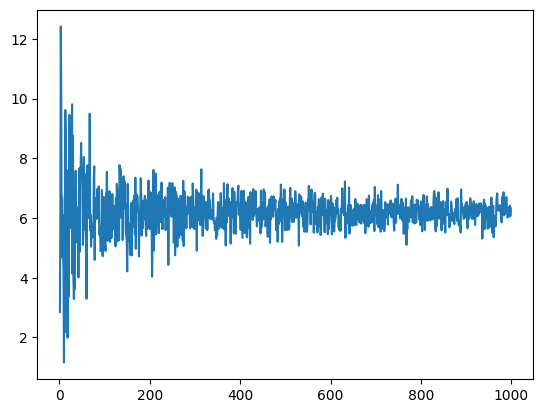

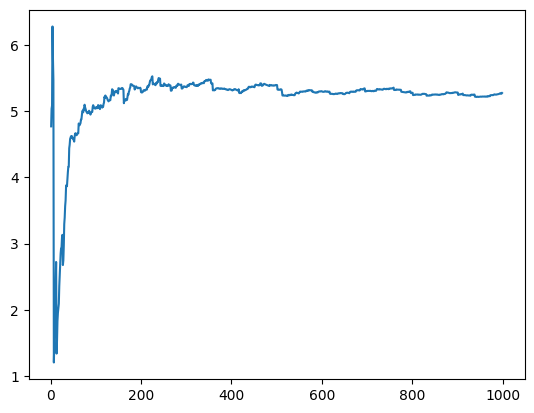

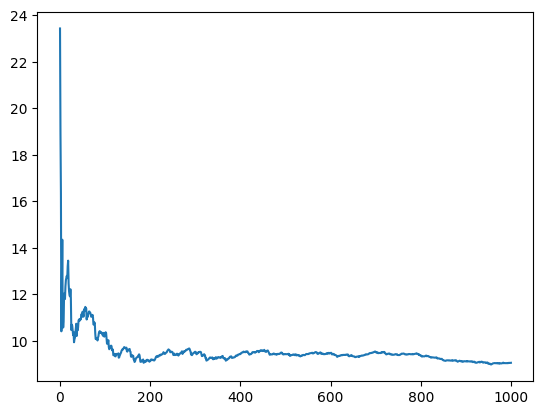

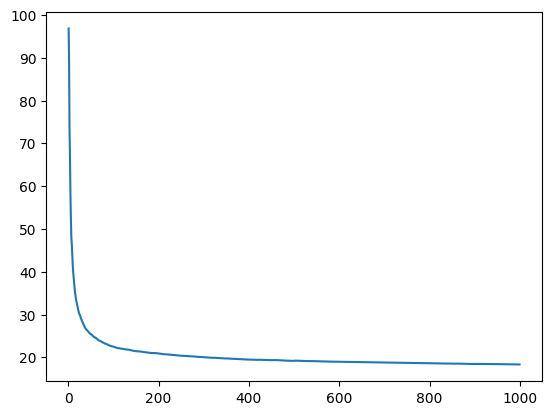

In [103]:
# Plots of changing total number of loans invested

# Plot random
plt.plot(return_results['num_loans'], return_results['avg_by_random'])
plt.show()

# Plot risk
plt.plot(return_results['num_loans'], return_results['avg_by_risk'])
plt.show()

# Plot return
plt.plot(return_results['num_loans'], return_results['avg_by_return'])
plt.show()

# Plot expected return
plt.plot(return_results['num_loans'], return_results['avg_by_expected_return'])
plt.show()


In [104]:
# Module 5

In [105]:
df_module5 = final_loans_dropped.copy()
df_module5

,id,loan_amnt,term,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,dti,earliest_cr_line,revol_bal,revol_util,open_acc,loan_length,ret_OPT
4,10129506,20800.0,36 months,10.0,RENT,81500.0,1.385856e+09,Fully Paid,debt_consolidation,16.73,8.966592e+08,23473.0,54.5,29.0,16.953120,10.640111
6,10179520,3000.0,36 months,10.0,RENT,25000.0,1.385856e+09,Fully Paid,debt_consolidation,24.68,6.730560e+08,2875.0,54.2,5.0,6.965235,10.426003
7,10139658,12000.0,36 months,10.0,RENT,40000.0,1.385856e+09,Fully Paid,debt_consolidation,16.94,9.072000e+08,5572.0,68.8,7.0,20.994271,6.476895
10,10148122,12000.0,36 months,3.0,MORTGAGE,96500.0,1.385856e+09,Fully Paid,debt_consolidation,12.61,1.062374e+09,13248.0,55.7,17.0,29.996509,4.659009
12,10149577,28000.0,36 months,5.0,MORTGAGE,325000.0,1.385856e+09,Fully Paid,debt_consolidation,18.55,7.836480e+08,29581.0,54.6,15.0,7.983737,6.178525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188115,1061272,8650.0,36 months,9.0,RENT,55000.0,1.325376e+09,Fully Paid,car,17.61,1.091318e+09,8052.0,71.3,10.0,25.955358,10.340310
188117,1062337,12000.0,36 months,3.0,MORTGAGE,42000.0,1.325376e+09,Fully Paid,credit_card,9.83,9.860832e+08,14378.0,52.3,9.0,14.981827,6.829726
188118,1062400,20500.0,36 months,7.0,RENT,60000.0,1.325376e+09,Fully Paid,debt_consolidation,16.40,5.916672e+08,15417.0,58.4,10.0,34.004805,9.771543
188119,1059394,15000.0,36 months,3.0,RENT,57600.0,1.325376e+09,Fully Paid,small_business,8.35,1.072915e+09,8897.0,33.1,18.0,36.008953,8.421728


In [106]:
# Grab only float featues
features_scaled = ['emp_length', 'loan_amnt', 'annual_inc', 'dti', 'revol_util', 'revol_bal', 'open_acc']

# Store the mean and std in variables
df_means = df_module5[features_scaled].mean()
df_std = df_module5[features_scaled].std()

In [144]:
# Train/Test Dataframe
df_module5_TT = df_module5.copy()

# Drop unnecessary columns

df_module5_TT.drop(['id', 'ret_OPT', 'loan_length', 'issue_d', 'earliest_cr_line'], axis=1, inplace=True)

# loan_status conversion
df_module5_TT.loan_status.replace('Default', 0, inplace = True)
df_module5_TT.loan_status.replace('Fully Paid', 1, inplace = True)

# Split into x and y
df_y = df_module5_TT.loan_status
df_x = df_module5_TT.drop('loan_status', axis=1)

# Categorical one-hot encoding coversion
updated_features_dict = {}
count=0
categorical_list = df_x.columns[df_x.dtypes == 'object'].to_list()

one_hot_df = pd.DataFrame()

for item in categorical_list:
    one_hot = pd.get_dummies(df_x[item])
    one_hot_df = pd.concat([one_hot_df,one_hot], axis=1)

df_x = df_x.drop(categorical_list, axis=1)
df_x = pd.concat([df_x, one_hot_df], axis=1)

In [145]:
# Split into train and test data   
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

# Scale data
x_train[features_scaled] = StandardScaler().fit_transform(x_train[features_scaled])
x_test[features_scaled] = StandardScaler().fit_transform(x_test[features_scaled])


In [147]:
%%time
# k-means
wcss = [] 
for i in range(1, 20): 
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(x_train) 
    wcss.append(kmeans.inertia_)

CPU times: user 3min 42s, sys: 2.87 s, total: 3min 45s
Wall time: 1min


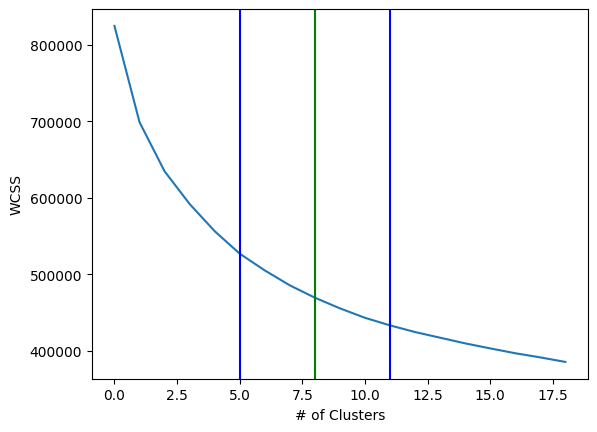

In [149]:
# Elbow method
cluster_range = pd.DataFrame(wcss,columns=['inertia'])
cluster_range = cluster_range.reset_index()
plt.plot(cluster_range['index'],cluster_range['inertia'])
plt.xlabel('# of Clusters')
plt.ylabel('WCSS') 
plt.axvline(x=5, color='b', label = 'optimal k-cluster value')
plt.axvline(x=8, color='g', label = 'optimal k-cluster value')
plt.axvline(x=11, color='b', label = 'optimal k-cluster value')

In [159]:
# Check number of loans in each cluster
opt_k = 8
kmeans = KMeans(n_clusters = opt_k, random_state = 42)
kmeans.fit(x_train)
# Join cluster values to x_train
x_train['cluster_value'] = kmeans.labels_

In [162]:
# Run KNN
neigh = KNeighborsClassifier(n_neighbors=8)
KNN_model = neigh.fit(x_train.drop('cluster_value', axis=1),x_train['cluster_value'])

In [163]:
KNN_model.predict(x_test)

array([1, 3, 0, ..., 3, 5, 4], dtype=int32)